In [1]:
from Simulator import *

In [2]:
weights = []
for i in range(8):
    weights.append(randint(0, 50))
for i in range(28):
    weights.append(randint(-50, 50))
print(weights)

[34, 0, 30, 21, 35, 9, 43, 42, 47, 31, -35, -44, -18, 10, -7, 14, -40, -2, -34, 11, 1, -37, -32, -11, 27, 17, 30, -36, 33, 19, 44, 18, 4, -9, -50, -15]


(692, (0, 1, 1, 0, 1, 1, 1, 1))


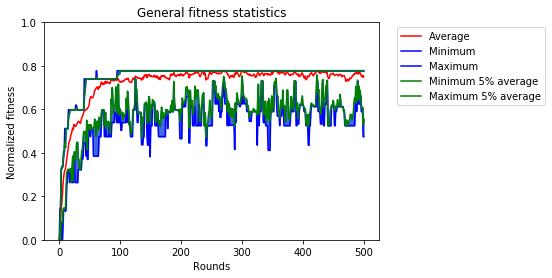

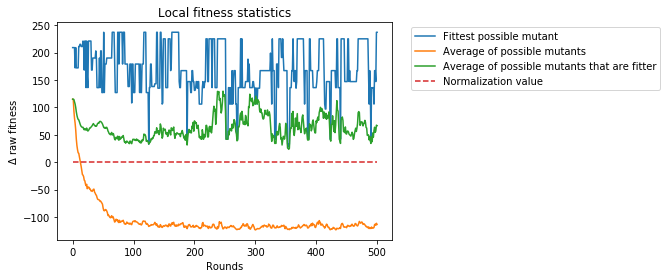

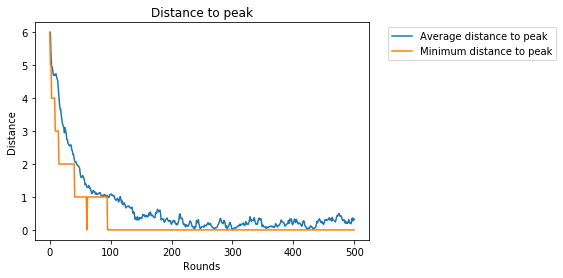

/home/alexandru/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


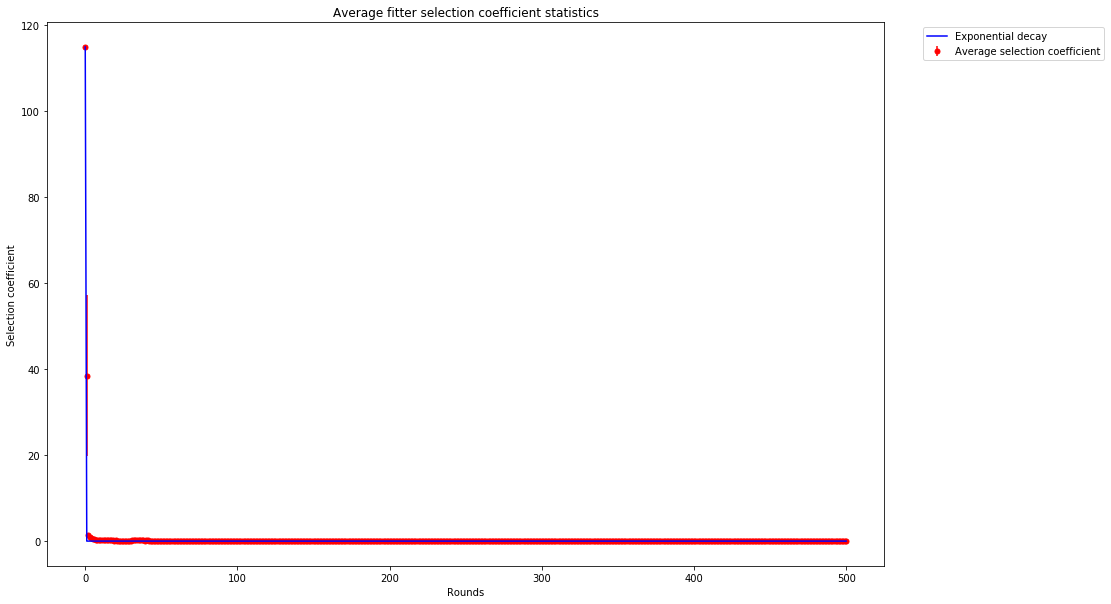

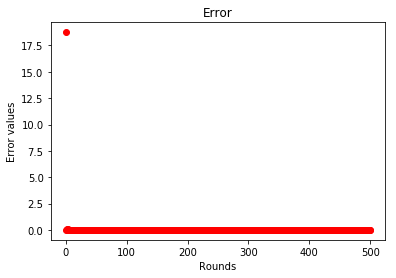

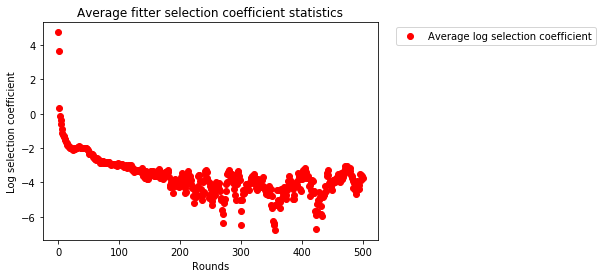

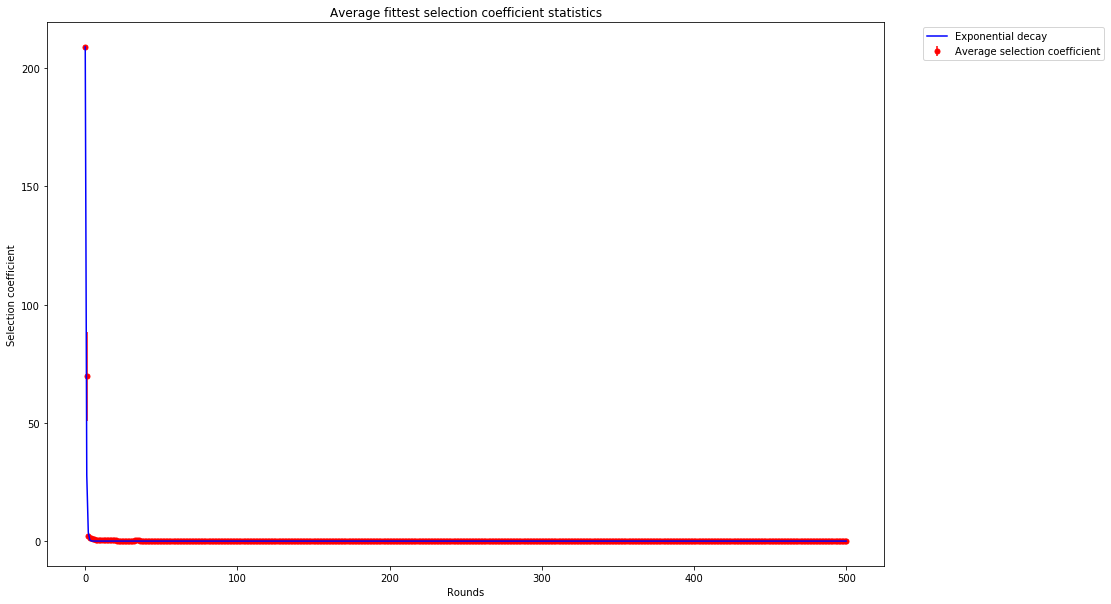

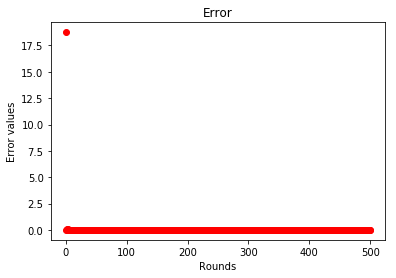

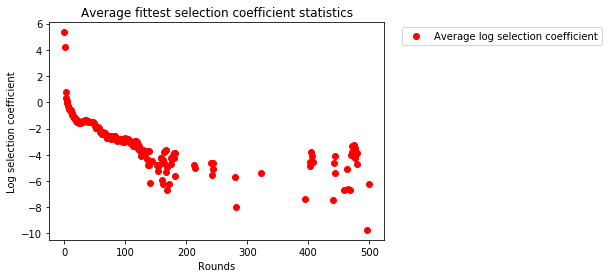

In [5]:
initial = [0] * 8
probability = 0.01
rounds = 500
orgNum = 100

constraints = []

weights = [31, 13, 16, 36, 32, 45, 22, 49, -32, -50, 49, -48, -18, -10, -20, 31, 14, -26, 43, 8, 34, 1, 35, -16, -1, -9, -7, -35, -7, -44, -2, -1, 43, -6, 50, -6]

l = 0

for i in range(8):
    constraints.append(ConstraintBinaryModelUnary(i, weights[l]))
    l += 1
    
for i in range(7):
    for j in range(i + 1, 8):
        w = weights[l]
        l += 1
        if w < 0:
            constraints.append(ConstraintBinaryModelBinaryDifferent([i,j],[-w,-w]))
        else:
            constraints.append(ConstraintBinaryModelBinarySame([i,j],[0,w]))

mySim = Simulator(2, initial, probability, rounds, orgNum, constraints, None, 1, 1, False, [0, 1, 1, 0, 1, 1, 1, 1])
print(mySim.getMaxPossibleFitAndGenome())
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

In [4]:
def repeatedSimulation(consCode, initial, probability, rounds, orgNum, constraints, domains, fitOffset, mutType, rep):
    maxFit = []
    avgFit = []
    for i in range(rep):
        mySim = Simulator(consCode, initial, probability, rounds, orgNum, constraints, domains, fitOffset, mutType)
        mySim.run()
        currAvgFit = np.array(mySim.getAvgFit())
        currMaxFit = np.array(mySim.getMaxFit())
        avgFit.append(currAvgFit)
        maxFit.append(currMaxFit)
        print(i)
    maxFit = np.average(maxFit, axis = 0)
    avgFit = np.average(avgFit, axis = 0)
    plt.title("Fitness statistics")
    axes = plt.gca()
    axes.set_ylim([0,1])
    plt.xlabel("Rounds")
    plt.ylabel("Fitness")
    rnds = []
    for i in range(rounds + 1):
        rnds.append(i)
    plt.plot(rnds, maxFit, label = "Max fitness", color = 'green')
    plt.plot(rnds, avgFit, label = "Average fitness", color = 'red')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()

        

1022000003072
0
1
2
3
4
5
6
7
8
9


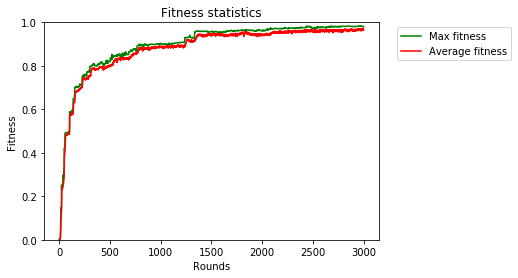

In [12]:
#initial = [1] * 18 + [0,0]
#initial = [0] * 18 + [1,1]
initial = [0] * 20
probability = 0.01
rounds = 3000
orgNum = 100

cache = {}
cachesp = {}
cachesm = {}
cachen = {}
def myFunc(args):
    
    def neighbours(x):
        tx = tuple(x)
        if tx in cachen:
            return cachen[tx]
        res = []
        for i in range(len(x)):
            curr = x.copy()
            curr[i] = 1 - curr[i]
            res.append(curr)
        cachen[tuple(x)] = res
        return res
    
    def s_plus(x):
        tx = tuple(x)
        if tx in cachesp:
            return cachesp[tx]
        fx = myFunc(x)
        mxm = 0
        for y in neighbours(x):
            fy = myFunc(y)
            mxm = max(mxm, fy - fx)
        cachesp[tx] = mxm
        return mxm
    
    def s_minus(x):
        tx = tuple(x)
        if tx in cachesm:
            return cachesm[tx]
        fx = myFunc(x)
        mnm = 1000000000
        spx = s_plus(x)
        for y in neighbours(x):
            fy = myFunc(y)
            if fx + spx > fy and fy > fx:
                mnm = min(mnm, fy - fx)
        if mnm == 1000000000:
            mnm = 0
        cachesm[tx] = mnm
        return mnm
    
    def xor (xs,ys):
        res = []
        for (x,y) in zip(xs,ys):
            if x == y:
                res.append(0)
            else:
                res.append(1)
        return res
    
    def bitfield(n):
        return [int(digit) for digit in bin(n)[2:]] # [2:] to chop off the "0b" part 
    
    m = len(args)
    sp = 1000000000
    sm = 1000000000
    
    for v in range(2 ^ (m - 1), 2 ^ m - 1):
        x = bitfield(v)
        sp = min(sp, s_plus(x))
        sm = min(sm, s_minus(x))
    
    if sm >= sp:
        sm = sp / 2
    
    targs = tuple(args)
    if targs in cache:       #if we already computed this function, return the cached value
        return cache[targs]
    if m == 2:
        if args == [0,0]:
            cache[targs] = 2
            return 2
        if args == [0,1]:
            cache[targs] = 3
            return 3
        if args == [1,0]:
            cache[targs] = 4
            return 4
        cache[targs] = 6
        return 6
    a = args[-2]
    b = args[-1]
    x = args[:-2]
    x_star = [0] * (m - 4) + [1,1]
    fx = myFunc(x)
    fx_star = myFunc(x_star)
    if a == 0 and b == 0:
        cache[targs] = fx
        return cache[targs]
    if a == 1 and b == 1:
        cache[targs] = myFunc(xor(x, x_star)) + fx_star + 2 * sp
        return cache[targs]
    if x != x_star:
        cache[targs] = fx + sm
        return cache[targs]
    if a == 0 and b == 1:
        cache[targs] = fx_star + sm
        return cache[targs]
    cache[targs] = fx_star + sp
    return cache[targs]
    

cons = ConstraintVCSP([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],(myFunc,1022000003072))
domain = [0,1]
domains = [domain] * 20
constraints = [cons]

print(myFunc([0] * 18 + [1,1]))

repeatedSimulation(3, initial, probability, rounds, orgNum, constraints, domains, 0, 1, 10)

#mySim = Simulator(3, initial, probability, rounds, orgNum, constraints, domains, 0, 1, False, [0] * 18 + [1,1])
#mySim.run()
#mySim.printStatistics()
#mySim.printLocalStatistics()

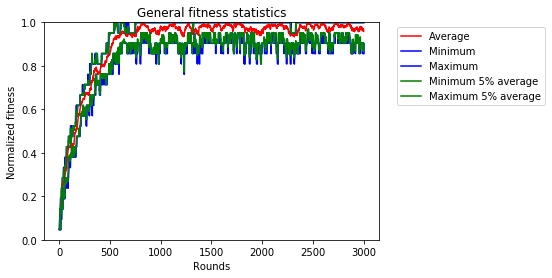

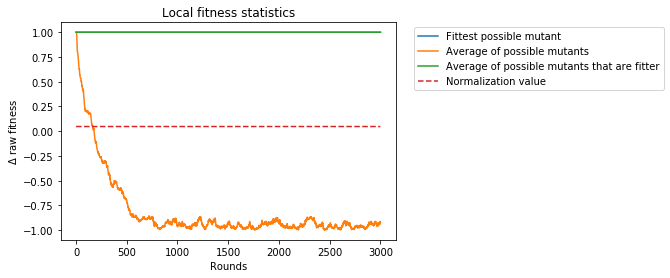

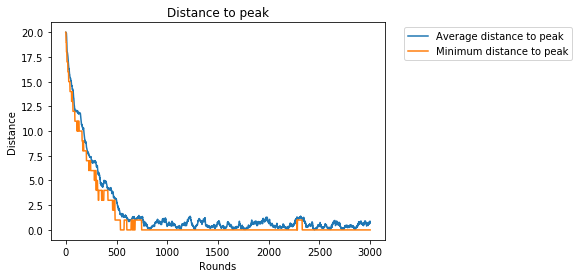

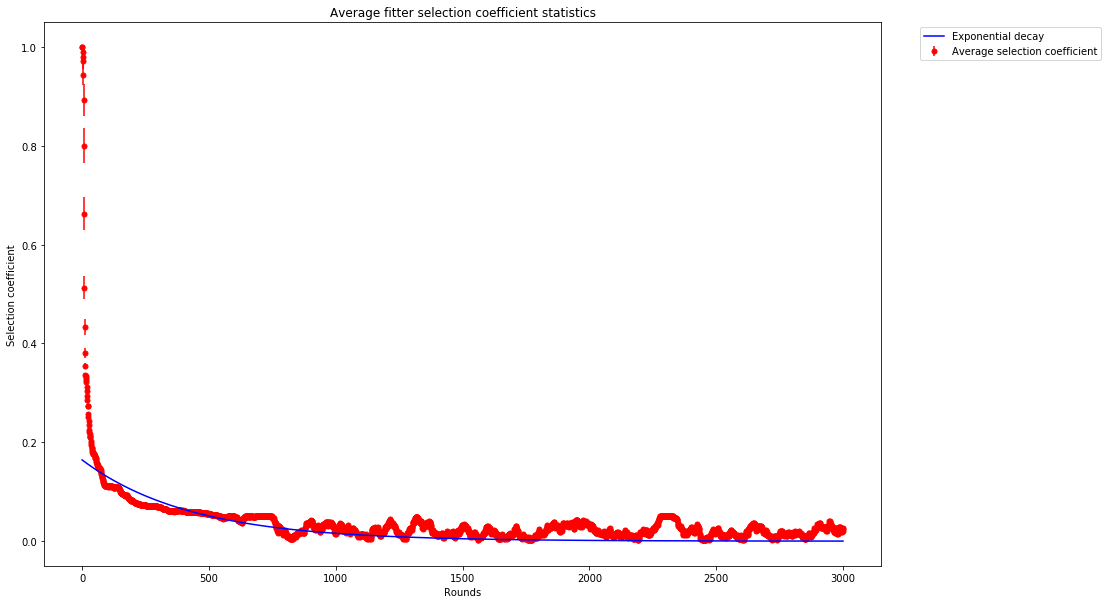

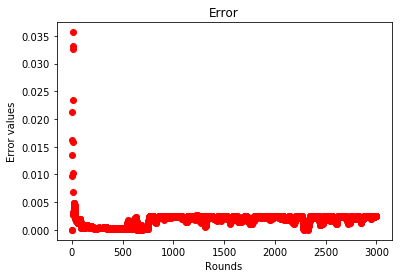

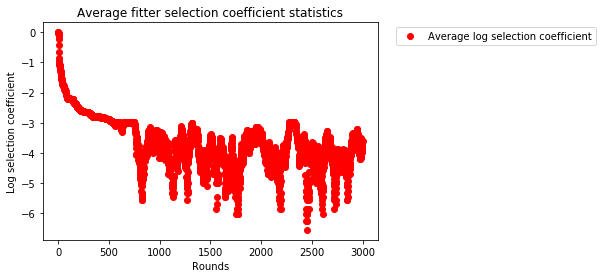

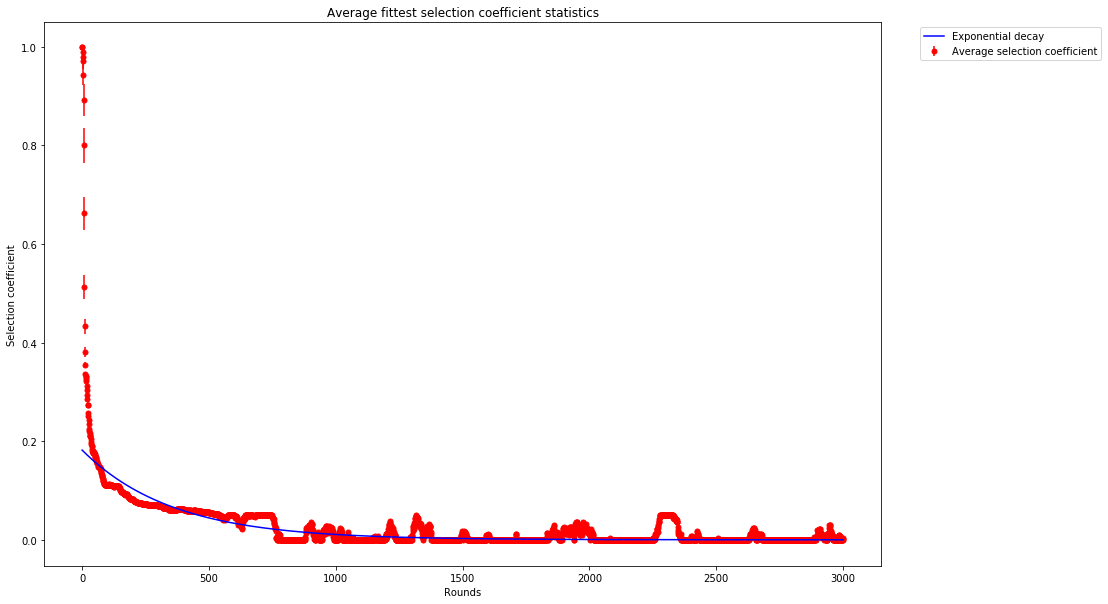

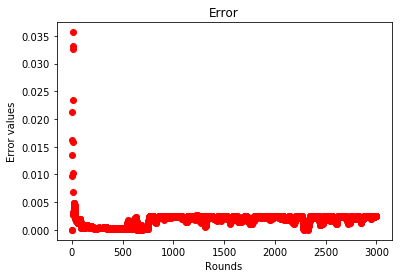

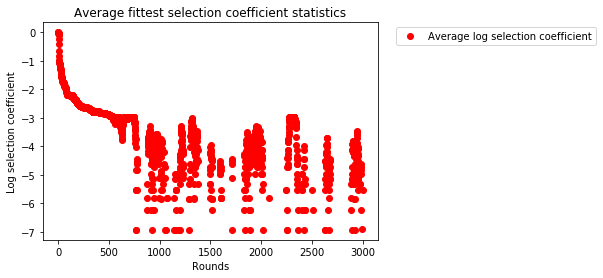

CPU times: user 1min 56s, sys: 2.35 s, total: 1min 58s
Wall time: 1min 55s


In [14]:
%%time

initial = [0] * 20
#initial = [1] * 18 + [0,0]
probability = 0.01
rounds = 3000
orgNum = 100
clause1 = ConstraintSat([1],1)
clause2 = ConstraintSat([2],1)
clause3 = ConstraintSat([3],1)
clause4 = ConstraintSat([4],1)
clause5 = ConstraintSat([5],1)
clause6 = ConstraintSat([6],1)
clause7 = ConstraintSat([7],1)
clause8 = ConstraintSat([8],1)
clause9 = ConstraintSat([9],1)
clause10 = ConstraintSat([10],1)
clause11 = ConstraintSat([11],1)
clause12 = ConstraintSat([12],1)
clause13 = ConstraintSat([13],1)
clause14 = ConstraintSat([14],1)
clause15 = ConstraintSat([15],1)
clause16 = ConstraintSat([16],1)
clause17 = ConstraintSat([17],1)
clause18 = ConstraintSat([18],1)
clause19 = ConstraintSat([19],1)
clause20 = ConstraintSat([20],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8, clause9, clause10, clause11, clause12, clause13, clause14, clause15, clause16, clause17, clause18, clause19, clause20]

#repeatedSimulation(1, initial, probability, rounds, orgNum, clauses, None, 1, 1, 10)

mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1, 1, False, [1] * 20)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

0
1
2
3
4
5
6
7
8
9


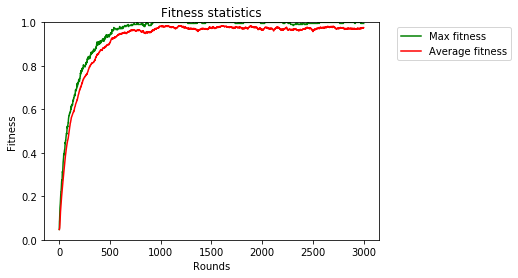

CPU times: user 16min 51s, sys: 324 ms, total: 16min 51s
Wall time: 16min 50s


In [12]:
%%time

initial = [0] * 20
#initial = [1] * 18 + [0,0]
probability = 0.01
rounds = 3000
orgNum = 100
clause1 = ConstraintSat([1],1)
clause2 = ConstraintSat([2],1)
clause3 = ConstraintSat([3],1)
clause4 = ConstraintSat([4],1)
clause5 = ConstraintSat([5],1)
clause6 = ConstraintSat([6],1)
clause7 = ConstraintSat([7],1)
clause8 = ConstraintSat([8],1)
clause9 = ConstraintSat([9],1)
clause10 = ConstraintSat([10],1)
clause11 = ConstraintSat([11],1)
clause12 = ConstraintSat([12],1)
clause13 = ConstraintSat([13],1)
clause14 = ConstraintSat([14],1)
clause15 = ConstraintSat([15],1)
clause16 = ConstraintSat([16],1)
clause17 = ConstraintSat([17],1)
clause18 = ConstraintSat([18],1)
clause19 = ConstraintSat([19],1)
clause20 = ConstraintSat([20],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8, clause9, clause10, clause11, clause12, clause13, clause14, clause15, clause16, clause17, clause18, clause19, clause20]

repeatedSimulation(1, initial, probability, rounds, orgNum, clauses, None, 1, 1, 10)

#mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1, 1, False, [1] * 20)
#mySim.run()
#mySim.printStatistics()
#mySim.printLocalStatistics()

/home/alexandru/.local/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/alexandru/.local/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/media/alexandru/C42E2B702E2B5AA6/Programare/Project/Evolution-Simulator/Simulator.py:455: RuntimeWarning: Degrees of freedom <= 0 for slice
  covFitFitter = np.cov([orgFit,orgAvgFitter], ddof = 1)           #covariance between orgFit and orgAvgFitter
/home/alexandru/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/alexandru/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/media/alexandru/C42E2B702E2B5AA6/Programare/Project/Evolution-Simulator/Simulat

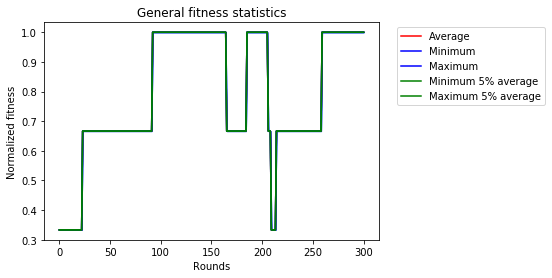

Constraint graph available only for binary constraints
CPU times: user 431 ms, sys: 215 ms, total: 646 ms
Wall time: 505 ms


In [2]:
%%time

initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.05
rounds = 300
orgNum = 1
clause1 = ConstraintSat([1],1)
clause2 = ConstraintSat([2],1)
clauses = [clause1, clause2]

mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1, 1, True)
mySim.run()
mySim.printStatistics()

#mySim.printLocalStatistics()
mySim.plotConstraintGraph()

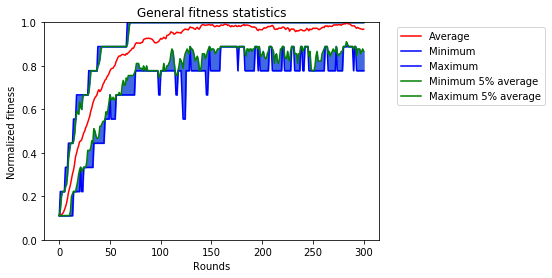

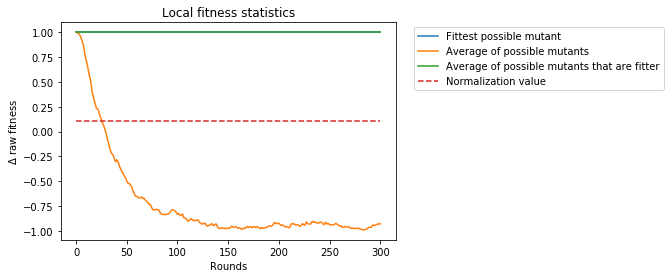

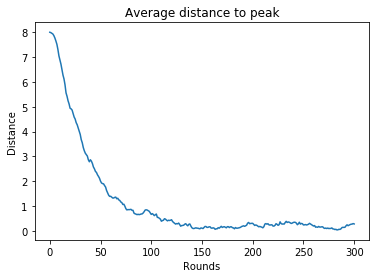

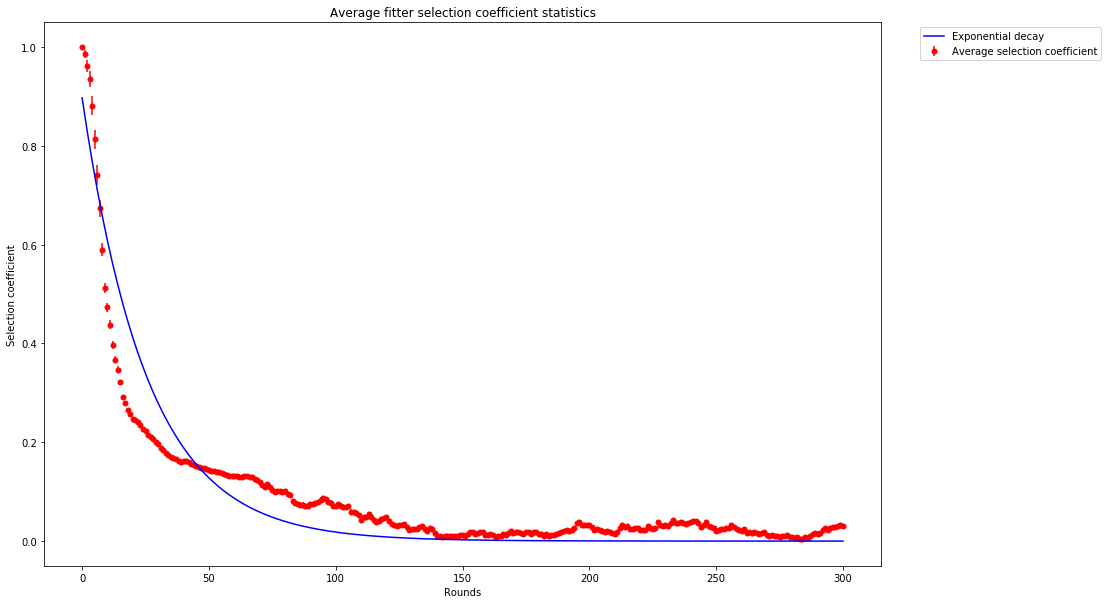

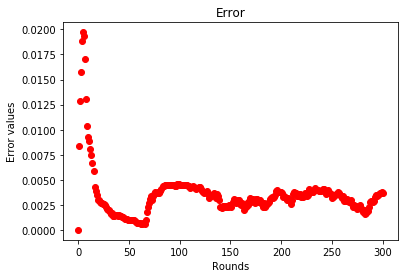

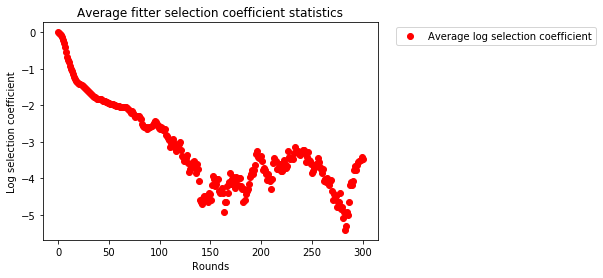

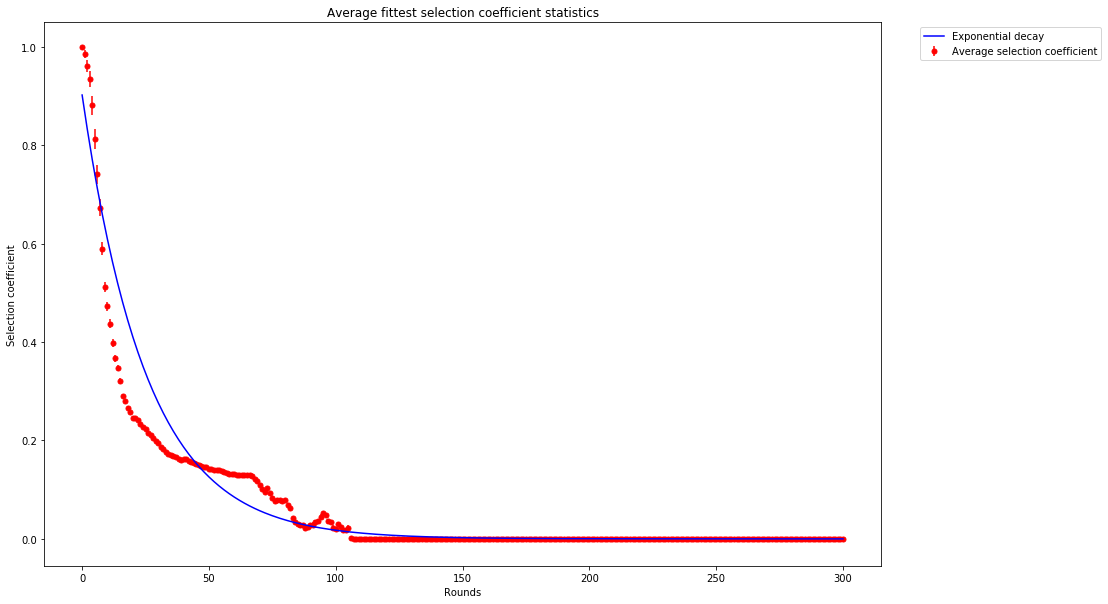

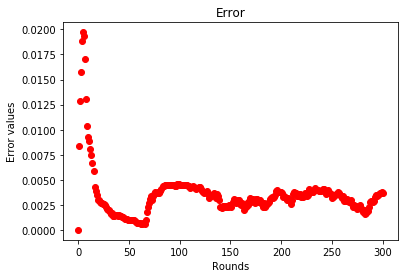

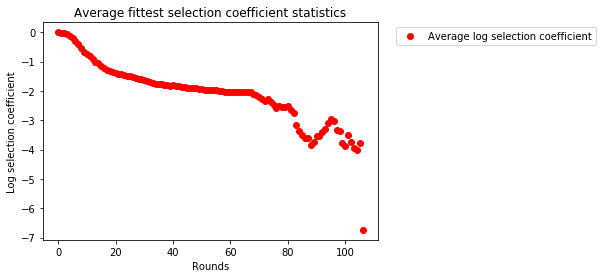

CPU times: user 8.13 s, sys: 2.12 s, total: 10.3 s
Wall time: 7.1 s


In [2]:
%%time

initial = [0] * 8
probability = 0.01
rounds = 300
orgNum = 200
clause1 = ConstraintSat([1],1)
clause2 = ConstraintSat([2],1)
clause3 = ConstraintSat([3],1)
clause4 = ConstraintSat([4],1)
clause5 = ConstraintSat([5],1)
clause6 = ConstraintSat([6],1)
clause7 = ConstraintSat([7],1)
clause8 = ConstraintSat([8],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]
mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1, 1, True,[1] * 8)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

In [5]:
def distribModel(u, n, r, fitChild): #my theory 1
    p = np.zeros((n + 1, n + 1))
    v = np.zeros(n + 1)
    v[0] = 1
    for i in range(n):
        p[i][i+1] = u * (n - i) / n
        p[i + 1][i] = u * (i + 1) / n
        p[i][i] = 1 - u
    p[n][n] = 1 - u
    distrib = [v]
    print(p)
    for i in range(r):
        w = (v * fitChild).dot(p)
        c = 1 / np.sum(w)
        v = c * w
        distrib.append(v)
    return distrib

In [6]:
def normalize(v):
    c = 1 / np.sum(v)
    return c * v

In [7]:
def distribModel2(u, n, r, fitChild): #my theory 2
    p = np.zeros((n + 1, n + 1))
    v = np.zeros(n + 1)
    v[0] = 1
    for i in range(n):
        p[i][i+1] = u * (n - i) / n
        p[i + 1][i] = u * (i + 1) / n
        p[i][i] = 1 - u
    p[n][n] = 1 - u
    distrib = [v]
    for i in range(r):
        v = (v * fitChild).dot(p)
        distrib.append(normalize(v))
    return distrib

[[0.95    0.05    0.      0.      0.      0.      0.      0.      0.     ]
 [0.00625 0.95    0.04375 0.      0.      0.      0.      0.      0.     ]
 [0.      0.0125  0.95    0.0375  0.      0.      0.      0.      0.     ]
 [0.      0.      0.01875 0.95    0.03125 0.      0.      0.      0.     ]
 [0.      0.      0.      0.025   0.95    0.025   0.      0.      0.     ]
 [0.      0.      0.      0.      0.03125 0.95    0.01875 0.      0.     ]
 [0.      0.      0.      0.      0.      0.0375  0.95    0.0125  0.     ]
 [0.      0.      0.      0.      0.      0.      0.04375 0.95    0.00625]
 [0.      0.      0.      0.      0.      0.      0.      0.05    0.95   ]]
[[0.95    0.05    0.      0.      0.      0.      0.      0.      0.     ]
 [0.00625 0.95    0.04375 0.      0.      0.      0.      0.      0.     ]
 [0.      0.0125  0.95    0.0375  0.      0.      0.      0.      0.     ]
 [0.      0.      0.01875 0.95    0.03125 0.      0.      0.      0.     ]
 [0.      0.      0.    

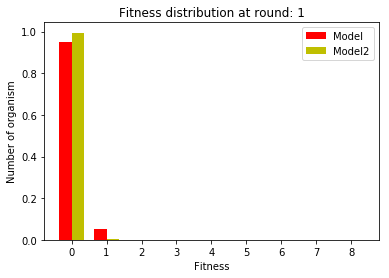

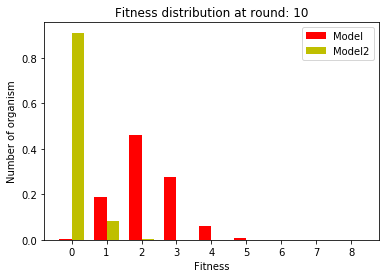

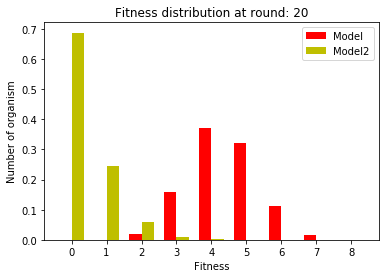

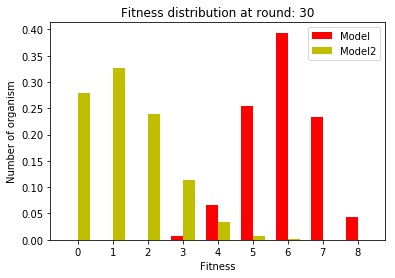

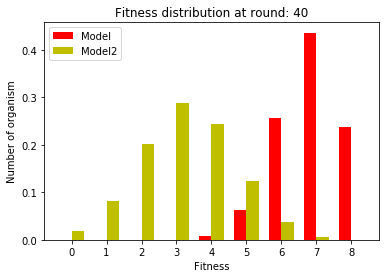

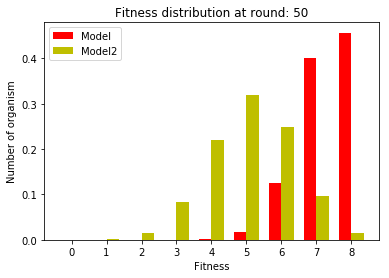

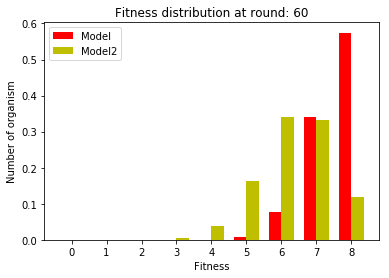

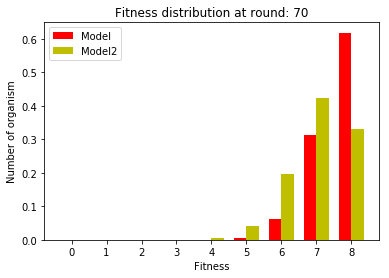

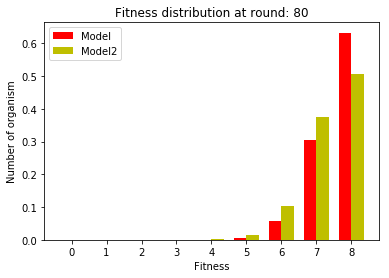

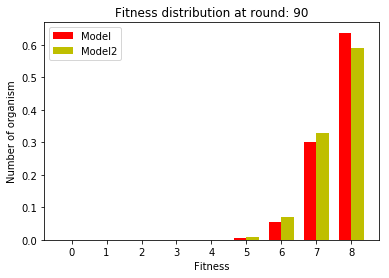

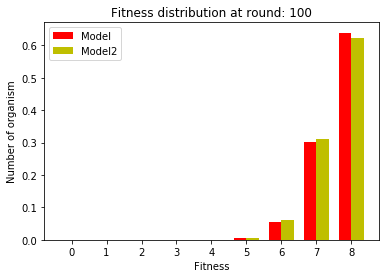

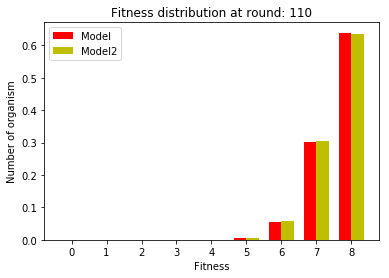

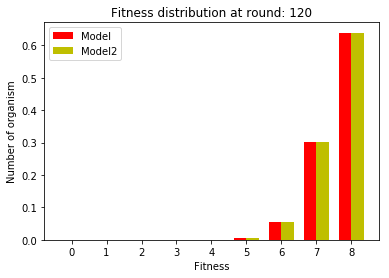

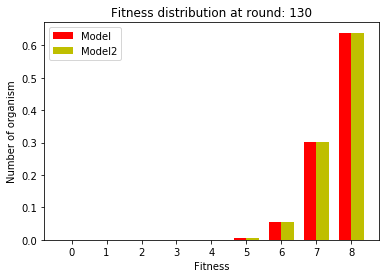

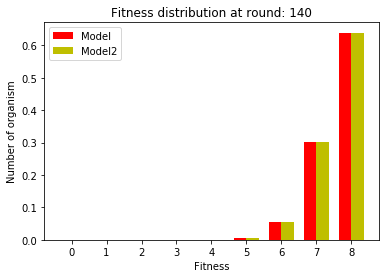

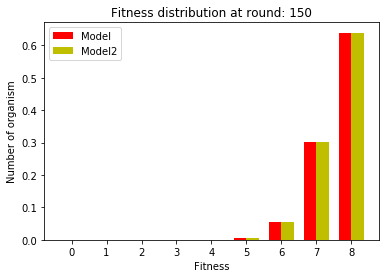

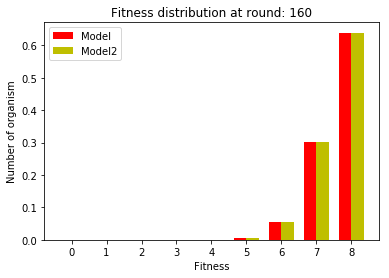

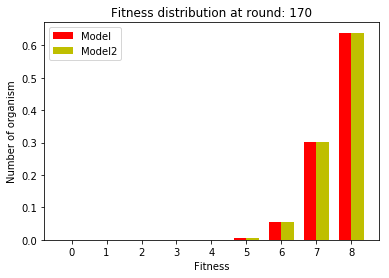

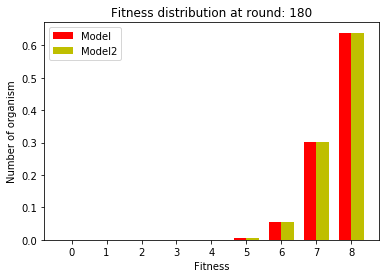

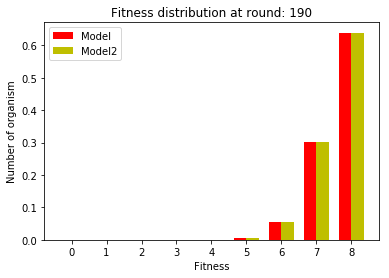

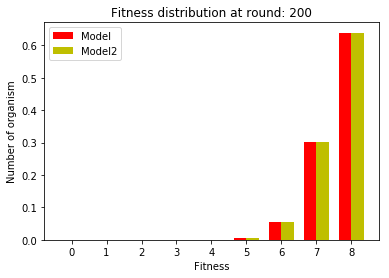

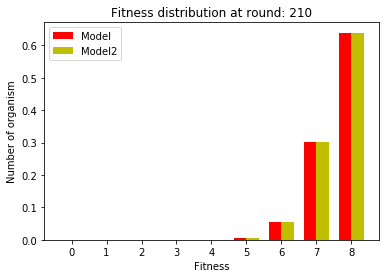

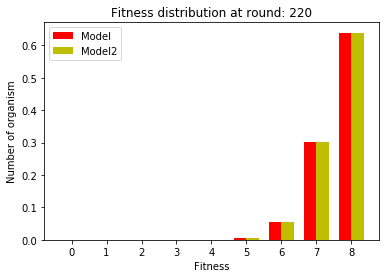

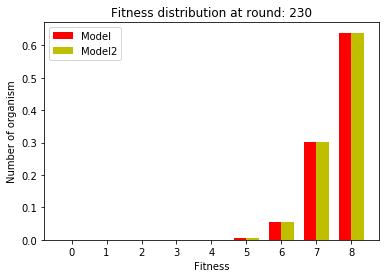

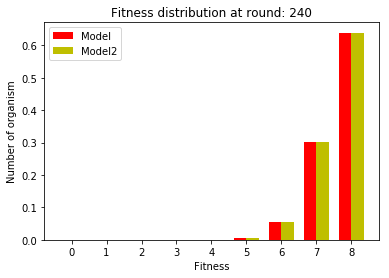

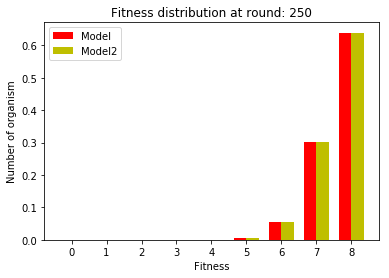

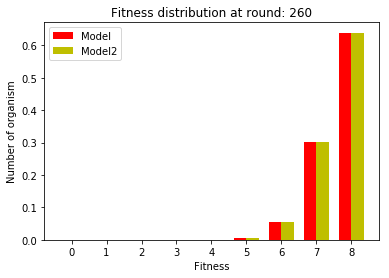

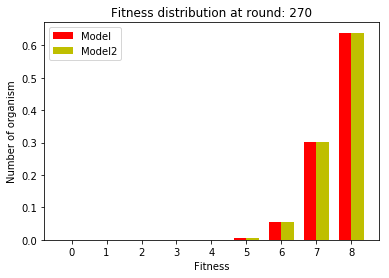

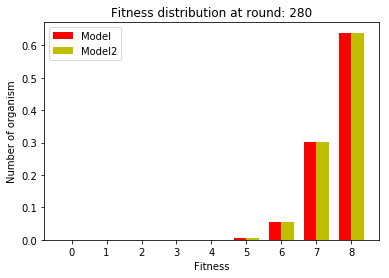

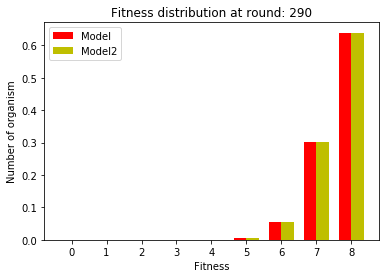

In [61]:
n = len(initial)
u = probability
m = orgNum
r = rounds
fc = [1,2,3,4,5,6,7,8,9]
rep = 30
distrib = distribModel(u, n, r, fc)
distrib2 = distribModel3(u, n, r, fc)

for i in range(int(r / 10)):
    i = i * 10
    if i == 0:
        i = 1
    width = 0.35
    ind = np.arange(n + 1)
    fig, ax = plt.subplots()
    plot1 = ax.bar(ind, distrib[i], width, color='r')
    plot2 = ax.bar(ind + width, distrib2[i], width, color='y')
    
    ax.set_ylabel('Number of organism')
    ax.set_title('Fitness distribution at round: ' + str(i))
    ax.set_xlabel('Fitness')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(tuple(map(lambda x: str(x), np.arange(n + 1))))
    
    ax.legend((plot1[0], plot2[0]), ('Model', 'Model2'))
    plt.show()

[[0.99    0.01    0.      0.      0.      0.      0.      0.      0.     ]
 [0.00125 0.99    0.00875 0.      0.      0.      0.      0.      0.     ]
 [0.      0.0025  0.99    0.0075  0.      0.      0.      0.      0.     ]
 [0.      0.      0.00375 0.99    0.00625 0.      0.      0.      0.     ]
 [0.      0.      0.      0.005   0.99    0.005   0.      0.      0.     ]
 [0.      0.      0.      0.      0.00625 0.99    0.00375 0.      0.     ]
 [0.      0.      0.      0.      0.      0.0075  0.99    0.0025  0.     ]
 [0.      0.      0.      0.      0.      0.      0.00875 0.99    0.00125]
 [0.      0.      0.      0.      0.      0.      0.      0.01    0.99   ]]
0


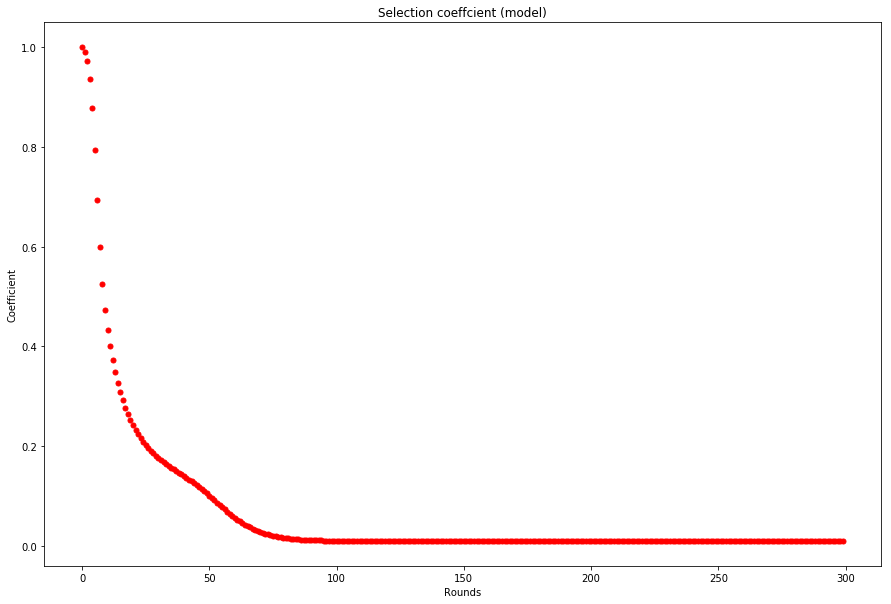

In [16]:
n = len(initial)
u = probability
m = orgNum
r = rounds
fc = [1,2,3,4,5,6,7,8,9]
rep = 1
distrib = distribModel(u, n, r, fc)
simDistrib = []
for i in range(rep):
    print(i)
    mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1, 1, True)
    mySim.run()
    dis = mySim.getDistribution()
    lstD = np.zeros((r,n + 1))
    for j in range(r):
        for k in dis[j]:
            lstD[j][k - 1] += dis[j][k]
    simDistrib.append(lstD.copy() / orgNum)
simStd = np.std(simDistrib, axis = 0)
simDistrib = np.average(simDistrib, axis = 0)

for i in range(int(r / 10)):
    i = i * 10
    if i == 0:
        i = 1
    md = distrib[i]
    sd = simDistrib[i]
    ssd = simStd[i]
    width = 0.35
    ind = np.arange(n + 1)
    #fig, ax = plt.subplots()
    #plot1 = ax.bar(ind, md, width, color='r')
    #plot2 = ax.bar(ind + width, sd, width, color='y', yerr = ssd)
    
    #ax.set_ylabel('Number of organism')
    #ax.set_title('Fitness distribution at round: ' + str(i))
    #ax.set_xlabel('Fitness')
    #ax.set_xticks(ind + width / 2)
    #ax.set_xticklabels(tuple(map(lambda x: str(x), np.arange(n + 1))))
    
    #ax.legend((plot1[0], plot2[0]), ('Model', 'Simulation'))
    #plt.show()

sims = []
models = []
rnds = []

simSel = []
aux = [1,1,1,1,1,1,1,1,0]

for i in range(r):
    sAvg = simDistrib[i].dot(np.array(fc) - 1)
    mAvg = distrib[i].dot(np.array(fc) - 1)
    mAvg2 = distrib[i].dot(np.array(fc))
    sims.append(sAvg)
    models.append(mAvg)
    rnds.append(i)
    simSel.append(distrib[i].dot(aux) / mAvg2)
    
plt.figure(figsize=(15,10))
plt.title("Selection coeffcient (model)")
plt.xlabel("Rounds")
plt.ylabel("Coefficient")
plt.plot(rnds, simSel,'ro', markersize=5)
plt.show()



#plt.title("Fitness statistics")
#plt.xlabel("Rounds")
#plt.ylabel("Average Fitness")
#plt.plot(rnds, sims, label = "Simulation")
#plt.plot(rnds, models, label = "Model")
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
#plt.show()



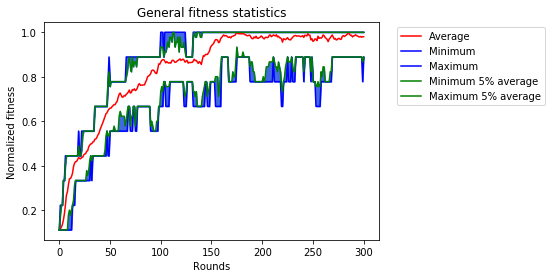

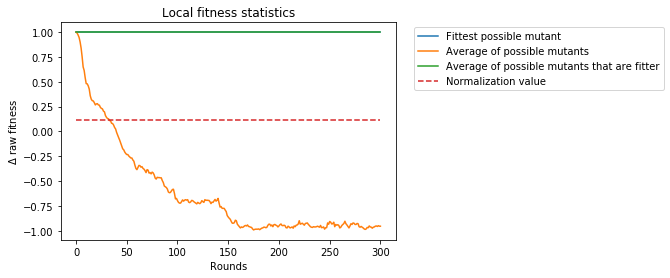

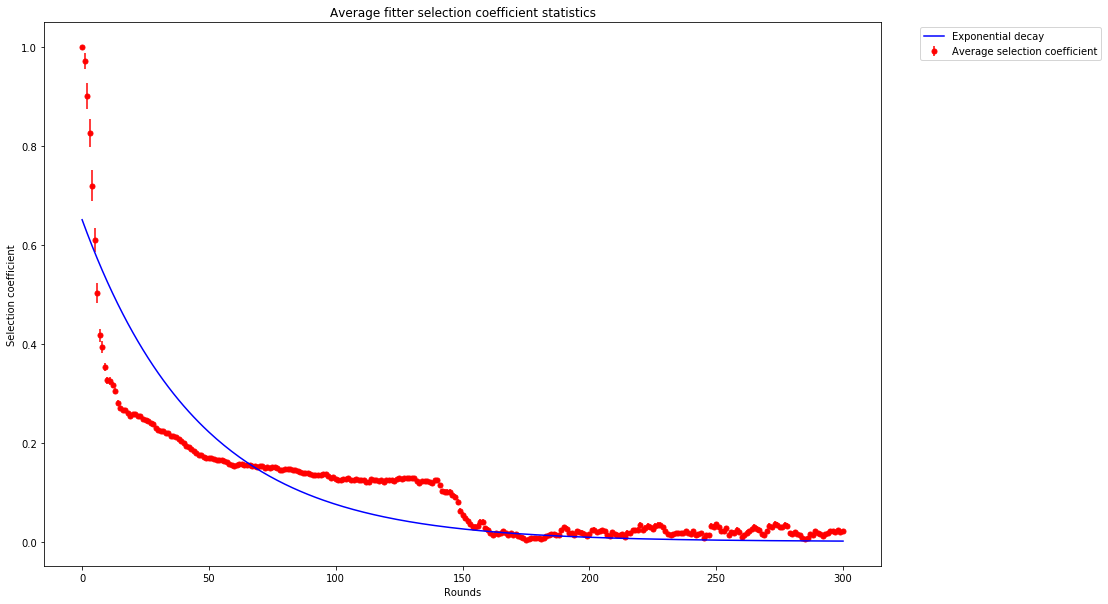

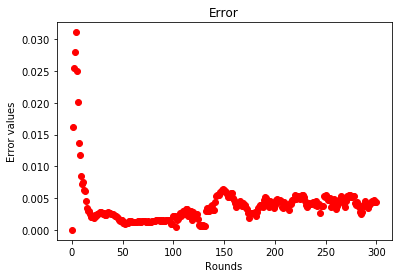

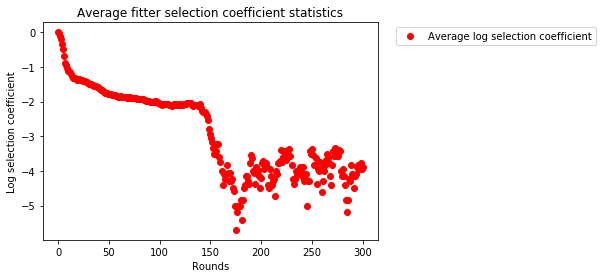

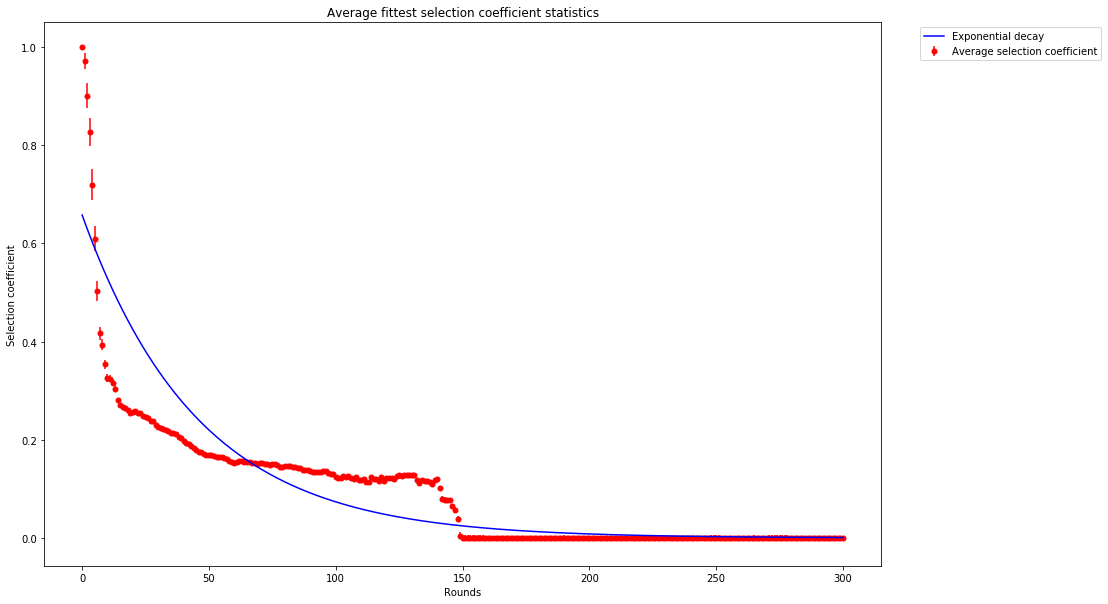

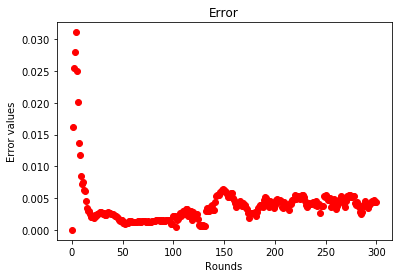

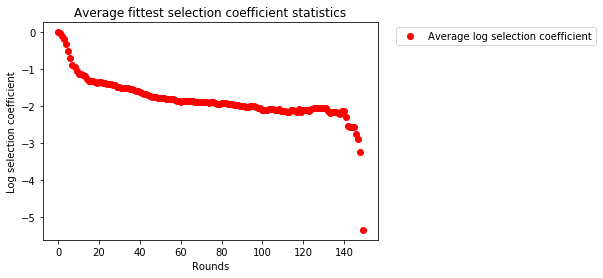

Constraint graph available only for binary constraints
CPU times: user 5.56 s, sys: 2 s, total: 7.56 s
Wall time: 4.66 s


In [24]:
%%time

initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.01
rounds = 300
orgNum = 100
clause1 = ConstraintSat([1],1)
clause2 = ConstraintSat([2],1)
clause3 = ConstraintSat([3],1)
clause4 = ConstraintSat([4],1)
clause5 = ConstraintSat([5],1)
clause6 = ConstraintSat([6],1)
clause7 = ConstraintSat([7],1)
clause8 = ConstraintSat([8],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()
mySim.plotConstraintGraph()

In [89]:
def simulate1 (p, orgNum, genLen, clauseNum, weight, f):
    initial = [0] * genLen
    probability = p
    rounds = 200
    clauses = []
    for i in range(0, clauseNum):
        clauses.append(ConstraintSat([i + 1], weight))
    mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1, 1)
    mySim.run()
    mySim.writeRunDataToFile(f)
    coeff = mySim.getExpCoeff()
    return coeff

(0.09315729513657973, 0.002277348150976179)
(0.13674254294345642, 0.0020378435194809592)
(0.1679629578322822, 0.002027017056085777)
(0.17160615969409415, 0.0020683483180246928)
(0.1669432201598081, 0.0020713504705286976)
(0.1842345604774237, 0.002042960728194025)
(0.2027130823717595, 0.002184333540398342)
(0.2557135953602566, 0.0023992502409491225)
(0.2927228243807078, 0.002609940908093683)
(0.32389918678065166, 0.0027054888680449257)
(0.3485420290174328, 0.0028669568926578608)


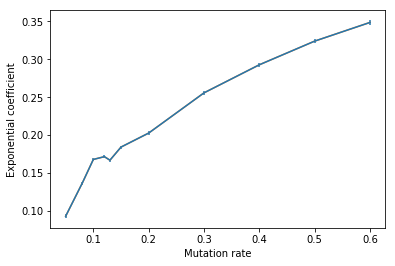

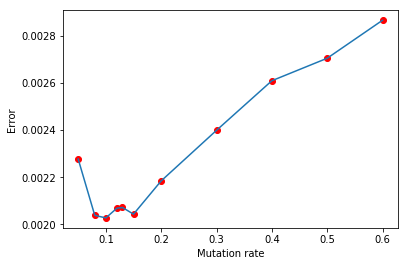

In [95]:
prob = [0.05, 0.08, 0.1, 0.12, 0.13,0.15,0.2,0.3, 0.4, 0.5, 0.6]
coeff = []
error = []

f = open("seeds.txt", "w")

runs = 5

for p in prob:
    cfAvg = 0
    erAvg = 0
    for i in range(runs):
        c = simulate1(p, 100, 20, 20, 1,f)
        cfAvg += c[0]
        erAvg += c[1]
    cfAvg /= runs
    erAvg /= runs
    print((cfAvg, erAvg))
    coeff.append(cfAvg)
    error.append(erAvg)
    
plt.ylabel("Exponential coefficient")
plt.xlabel("Mutation rate")
plt.errorbar(prob, coeff, yerr = error)
plt.plot(prob, coeff)
plt.show()
plt.ylabel("Error")
plt.xlabel("Mutation rate")
plt.plot(prob, error, 'ro')
plt.plot(prob, error)
plt.show()

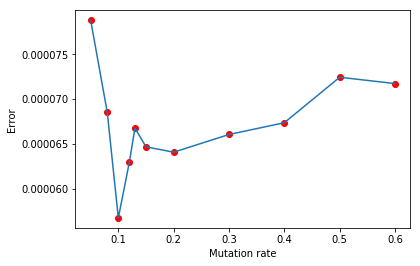

In [9]:
plt.ylabel("Error")
plt.xlabel("Mutation rate")
plt.plot(prob, np.array(error)**2/np.array(coeff), 'ro')
plt.plot(prob, np.array(error)**2/np.array(coeff))
plt.show()

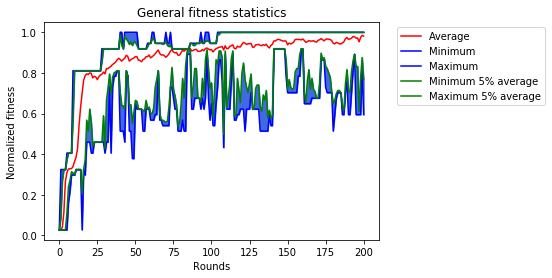

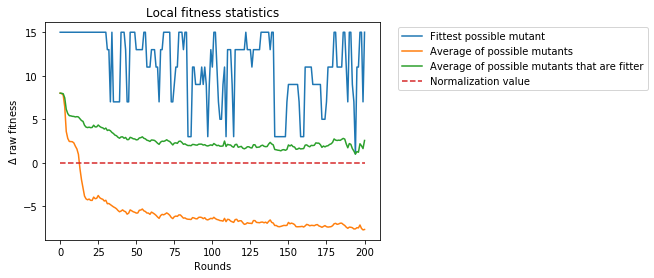

/media/alexandru/C42E2B702E2B5AA6/Programare/Project/Evolution-Simulator/Simulator.py:263: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-c*x)


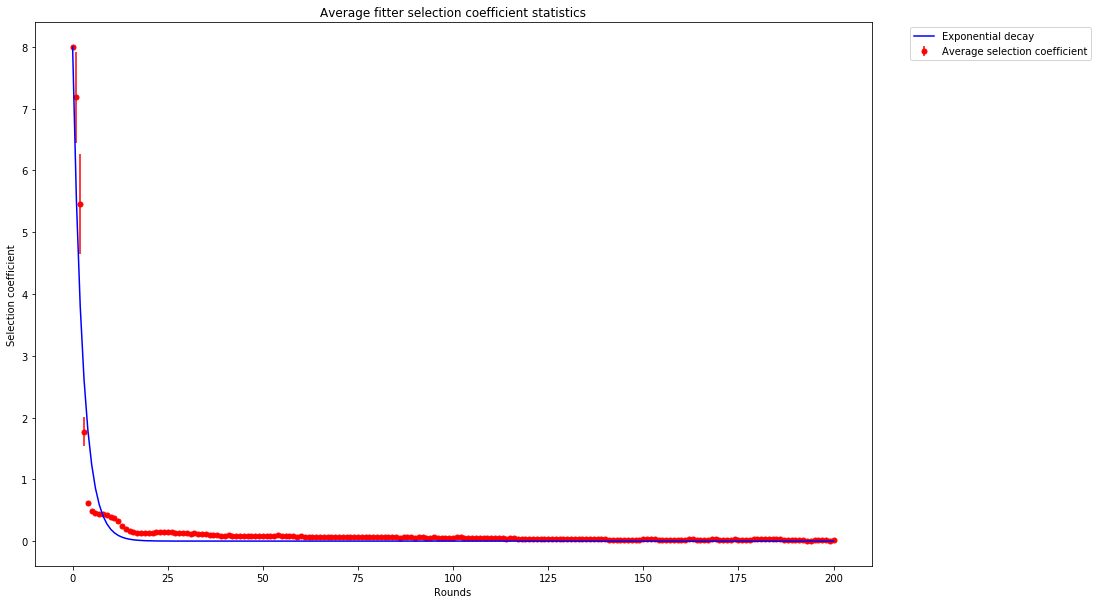

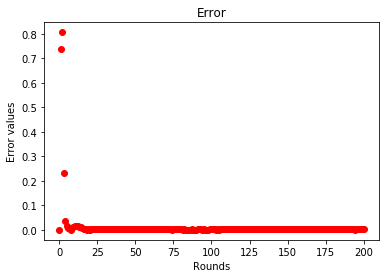

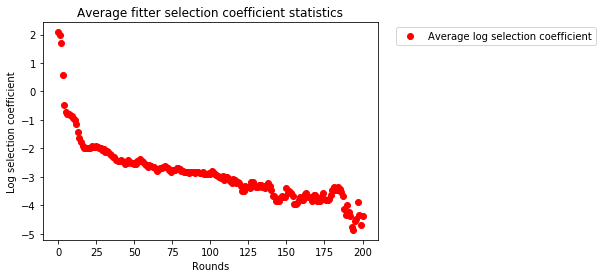

/home/alexandru/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:459: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)


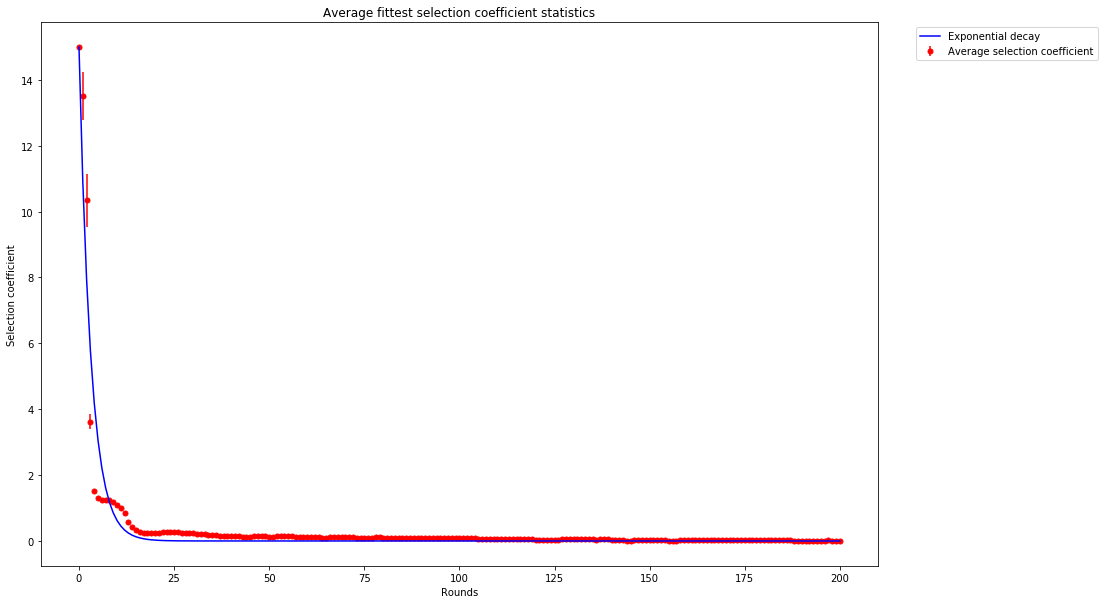

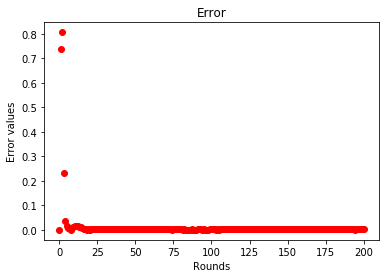

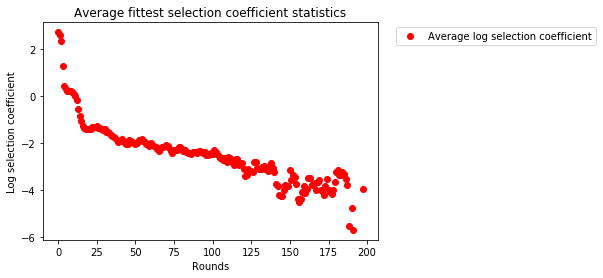

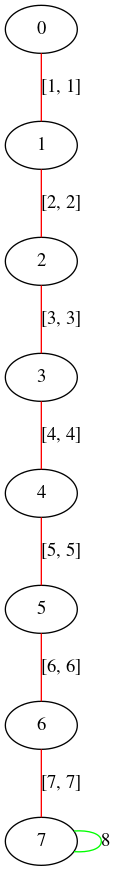

In [7]:
initial = [1, 0, 1, 0, 1, 0, 1, 0]
probability = 0.01
rounds = 200
orgNum = 100
cons0 = ConstraintBinaryModelUnary(7, 8)
cons1 = ConstraintBinaryModelBinarySame([0,1],[1,1])
cons2 = ConstraintBinaryModelBinarySame([1,2],[2,2])
cons3 = ConstraintBinaryModelBinarySame([2,3],[3,3])
cons4 = ConstraintBinaryModelBinarySame([3,4],[4,4])
cons5 = ConstraintBinaryModelBinarySame([4,5],[5,5])
cons6 = ConstraintBinaryModelBinarySame([5,6],[6,6])
cons7 = ConstraintBinaryModelBinarySame([6,7],[7,7])

constraints = [cons0, cons1,cons2,cons3,cons4,cons5,cons6,cons7]
mySim = Simulator(2, initial, probability, rounds, orgNum, constraints, None, 1, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()
G = mySim.plotConstraintGraph()
draw(G, show = 'ipynb')

(0.10913759773056841, 0.0020464549930738116)
(0.23188221764850936, 0.002920699692901911)


/media/alexandru/C42E2B702E2B5AA6/Programare/Project/Evolution-Simulator/Simulator.py:279: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-c*x)


(0.3383236723561991, 0.00357941863127804)


/media/alexandru/C42E2B702E2B5AA6/Programare/Project/Evolution-Simulator/Simulator.py:279: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-c*x)


(0.40637553203616444, 0.004458743491495283)
(0.53853456894035, 0.007158258445754307)
(0.6530380422769951, 0.010102016143926912)
(0.6575009483672338, 0.01741924201515786)
(0.7523893160761248, 0.022992358831288594)
(0.743242418454384, 0.03857884105049245)
(0.9529363833941492, 0.02766260934277342)
(1.071515277455503, 0.022540177303136632)
(1.1131813819939445, 0.030199196392130236)


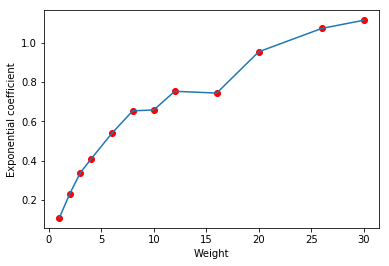

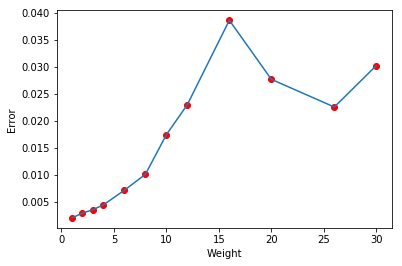

In [90]:
weights = [1,2,3,4,6,8,10,12,16,20,26,30]
coeff = []
error = []

f = open("seeds.txt", "w")

runs = 5

for w in weights:
    cfAvg = 0
    erAvg = 0
    for i in range(runs):
        c = simulate1(0.05, 200, 20, 20, w,f)
        cfAvg += c[0]
        erAvg += c[1]
    cfAvg /= runs
    erAvg /= runs
    print((cfAvg, erAvg))
    coeff.append(cfAvg)
    error.append(erAvg)
plt.ylabel("Exponential coefficient")
plt.xlabel("Weight")
plt.plot(weights, coeff, 'ro')
plt.plot(weights, coeff)
plt.show()
plt.ylabel("Error")
plt.xlabel("Weight")
plt.plot(weights, error, 'ro')
plt.plot(weights, error)
plt.show()

(0.0035859731672525617, 0.004590681821916543)
(0.005706585487518835, 0.004912659211175599)
(0.007909378117669263, 0.004537775676541254)
(0.07680634090900729, 0.005554280943056003)
(0.09796305665232136, 0.00453133739990616)
(0.1199900053629351, 0.0038232680709095026)
(0.13261093619938866, 0.0025443516251037294)
(0.1552084341655388, 0.002027030349679997)
(0.14757485192164954, 0.0015400124230138302)
(0.1477753334762421, 0.0013061037865048967)


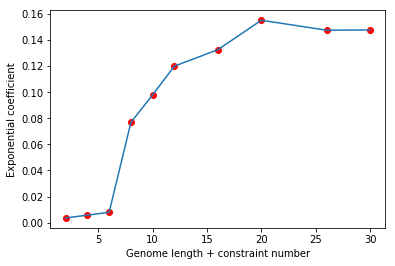

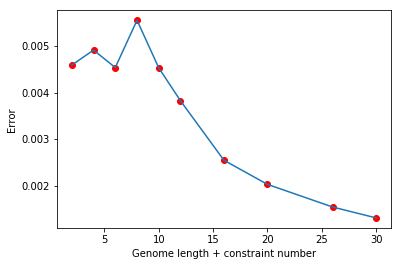

In [9]:
genLen = [2,4,6,8,10,12,16,20,26,30]
coeff = []
error = []

f = open("seeds.txt", "w")

runs = 5

for l in genLen:
    cfAvg = 0
    erAvg = 0
    for i in range(runs):
        c = simulate1(0.1, 100, l, l, 1,f)
        cfAvg += c[0]
        erAvg += c[1]
    cfAvg /= runs
    erAvg /= runs
    print((cfAvg, erAvg))
    coeff.append(cfAvg)
    error.append(erAvg)
plt.ylabel("Exponential coefficient")
plt.xlabel("Genome length + constraint number")
plt.plot(genLen, coeff, 'ro')
plt.plot(genLen, coeff)
plt.show()
plt.ylabel("Error")
plt.xlabel("Genome length + constraint number")
plt.plot(genLen, error, 'ro')
plt.plot(genLen, error)
plt.show()

In [10]:
def simulate2 (p, orgNum, genLen, clauseNum, weight,f):
    initial = [0,1] * genLen
    probability = p
    rounds = 200
    clauses = []
    x = 1
    clauses.append(ConstraintBinaryModelUnary(clauseNum - 1, 8))
    for i in range(0, clauseNum - 1):
        clauses.append(ConstraintBinaryModelBinarySame([i,i + 1],[i + 1,i + 1]))
    mySim = Simulator(2, initial, probability, rounds, orgNum, clauses, None, 1, 1)
    mySim.run()
    mySim.writeRunDataToFile(f)
    coeff = mySim.getExpCoeff()
    return coeff

(0.07819141012406865, 0.0011519116607712201)
(0.10542408545205942, 0.0009802444354532521)
(0.13102899198404774, 0.0008381836841428018)
(0.14745862190244674, 0.0008511893311915011)
(0.1613531715140361, 0.0013755637346588977)
(0.1571988828852283, 0.0018923894971801338)
(0.20516685703383297, 0.0025099607333623026)
(0.17522814366340367, 0.0029355169473606925)
(0.151831616284143, 0.003034360355723575)
(0.20839350852925137, 0.0034077786346090773)
(0.18835344464443524, 0.0039669743461165086)
(0.0948216488914271, 0.0033683181551267655)


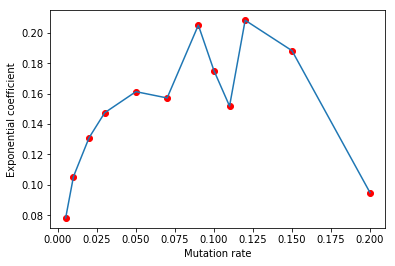

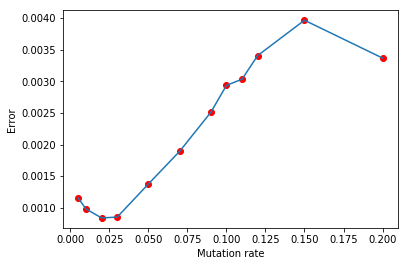

In [15]:
prob = [0.005, 0.01, 0.02, 0.03, 0.05, 0.07, 0.09,0.1, 0.11, 0.12, 0.15, 0.2]
coeff = []
error = []

f = open("seeds.txt", "w")

runs = 5

for p in prob:
    cfAvg = 0
    erAvg = 0
    for i in range(runs):
        c = simulate2(p, 100, 4, 8, 1,f)
        cfAvg += c[0]
        erAvg += c[1]
    cfAvg /= runs
    erAvg /= runs
    print((cfAvg, erAvg))
    coeff.append(cfAvg)
    error.append(erAvg)

plt.ylabel("Exponential coefficient")
plt.xlabel("Mutation rate")
plt.plot(prob, coeff, 'ro')
plt.plot(prob, coeff)
plt.show()
plt.ylabel("Error")
plt.xlabel("Mutation rate")
plt.plot(prob, error, 'ro')
plt.plot(prob, error)
plt.show()

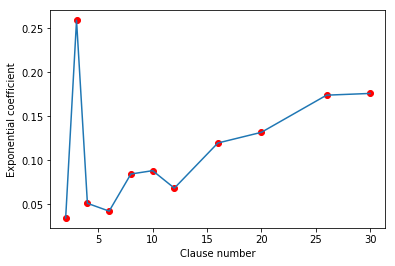

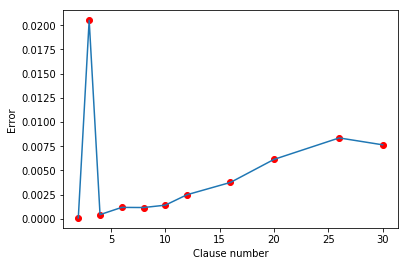

In [17]:
clauseNum = [2,3,4,6,8,10,12,16,20,26,30]
coeff = []
error = []

f = open("seeds.txt", "w")

runs = 5

for cNum in clauseNum:
    cfAvg = 0
    erAvg = 0
    for i in range(runs):
        c = simulate2(0.01, 100, cNum, cNum, 1,f)
        cfAvg += c[0]
        erAvg += c[1]
    cfAvg /= runs
    erAvg /= runs
    coeff.append(cfAvg)
    error.append(erAvg)
plt.ylabel("Exponential coefficient")
plt.xlabel("Clause number")
plt.plot(clauseNum, coeff, 'ro')
plt.plot(clauseNum, coeff)
plt.show()
plt.ylabel("Error")
plt.xlabel("Clause number")
plt.plot(clauseNum, error, 'ro')
plt.plot(clauseNum, error)
plt.show()

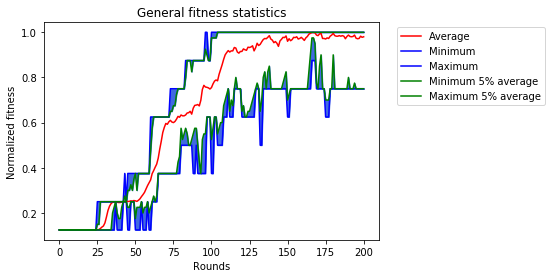

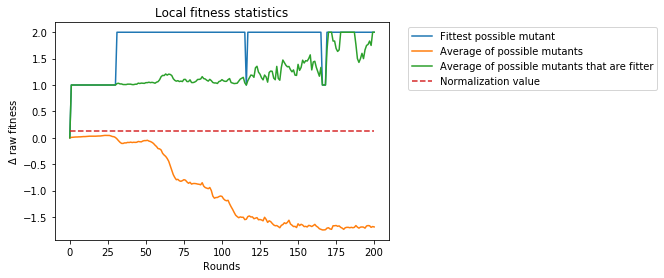

yeah


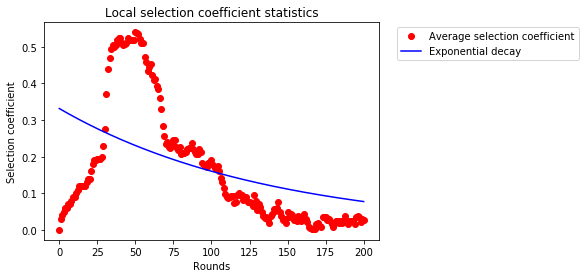

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:312: RuntimeWarning: divide by zero encountered in log


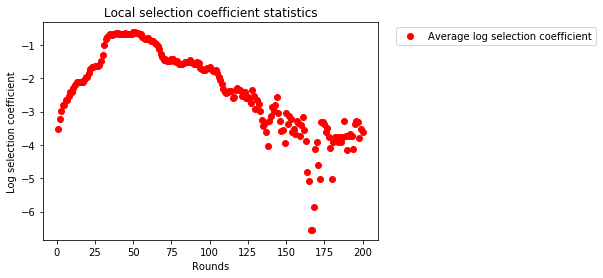

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: divide by zero encountered in power


yeah


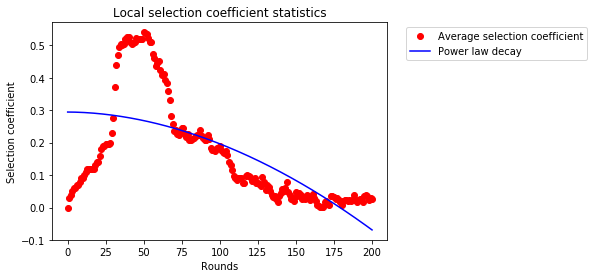

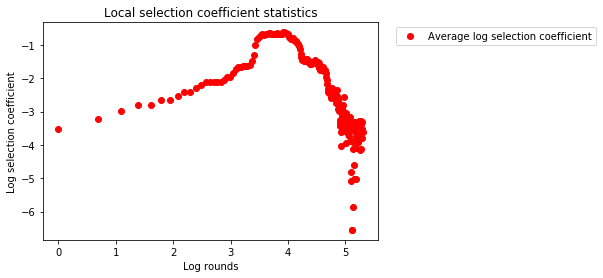

yeah


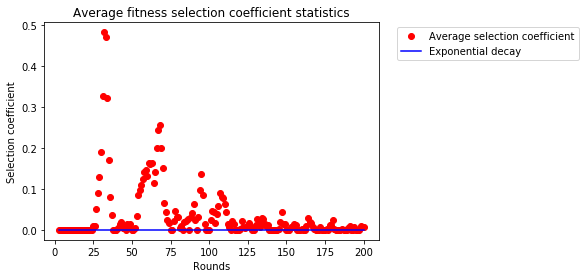

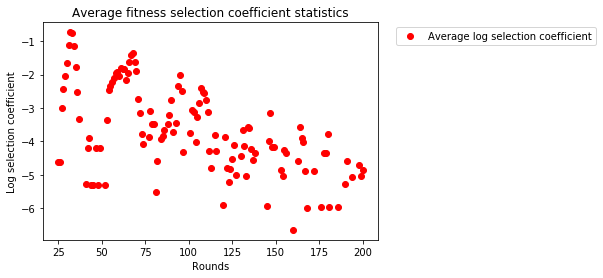

yeah


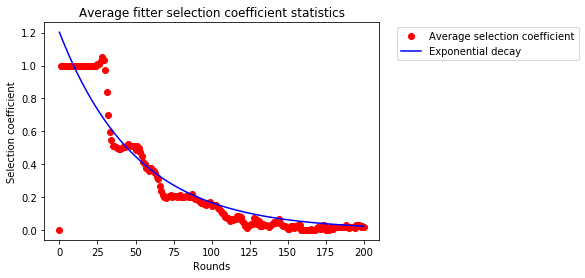

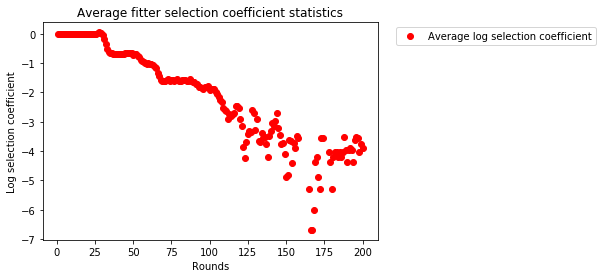

yeah


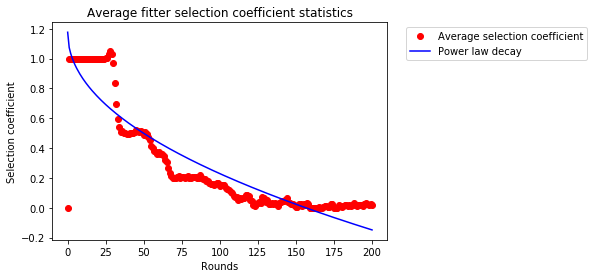

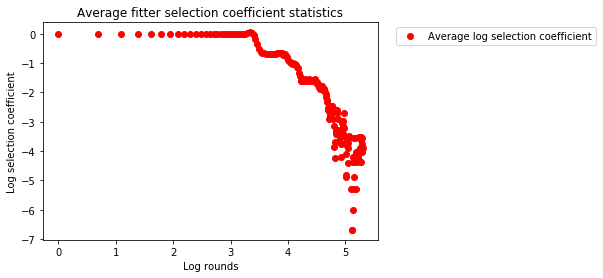

yeah


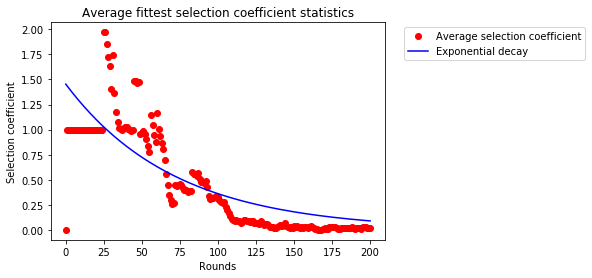

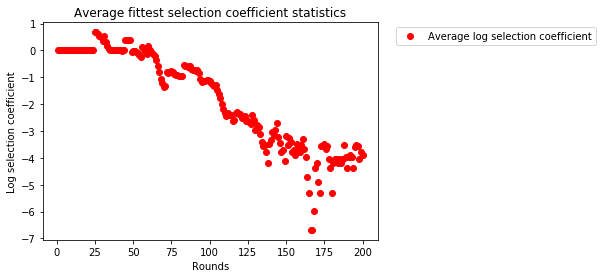

yeah


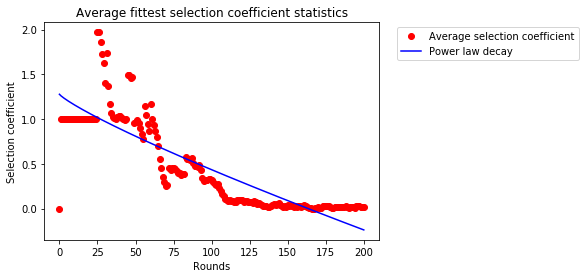

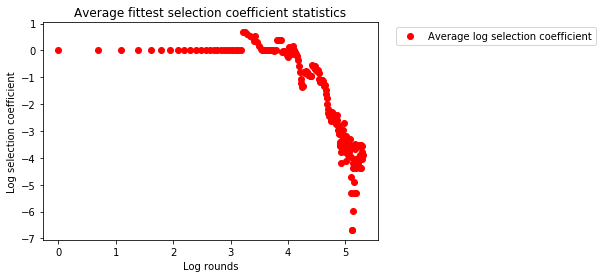

yeah


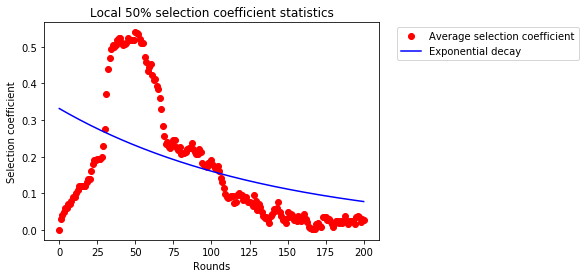

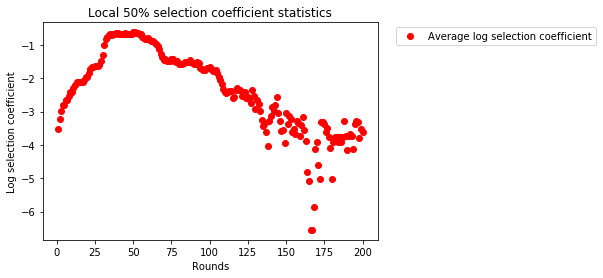

yeah


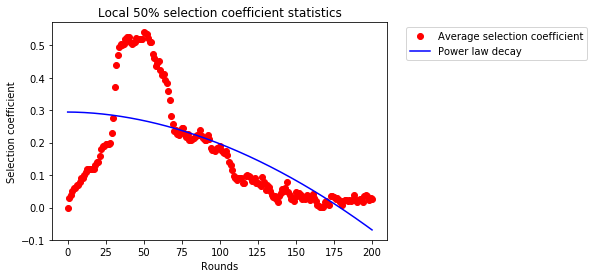

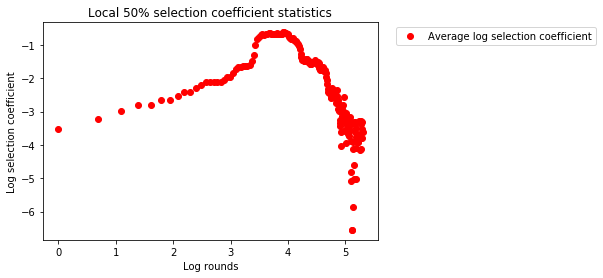

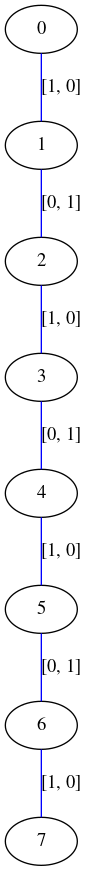

In [206]:
initial = [1, 0] * 4
probability = 0.01
rounds = 200
orgNum = 100
cons1 = ConstraintBinaryModelBinaryDifferent([0,1],[1,0])
cons2 = ConstraintBinaryModelBinaryDifferent([1,2],[0,1])
cons3 = ConstraintBinaryModelBinaryDifferent([2,3],[1,0])
cons4 = ConstraintBinaryModelBinaryDifferent([3,4],[0,1])
cons5 = ConstraintBinaryModelBinaryDifferent([4,5],[1,0])
cons6 = ConstraintBinaryModelBinaryDifferent([5,6],[0,1])
cons7 = ConstraintBinaryModelBinaryDifferent([6,7],[1,0])

constraints = [cons1,cons2,cons3,cons4,cons5,cons6,cons7]
mySim = Simulator(2, initial, probability, rounds, orgNum, constraints, None, 1, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()
G = mySim.plotConstraintGraph()
draw(G, show = 'ipynb')

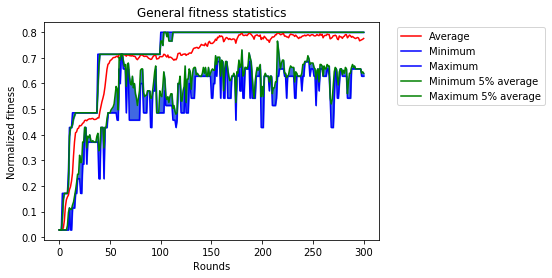

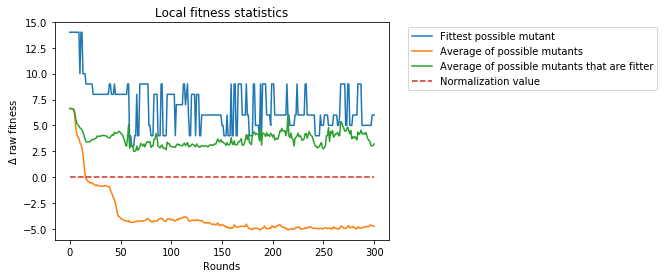

yeah


/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:259: RuntimeWarning: overflow encountered in exp


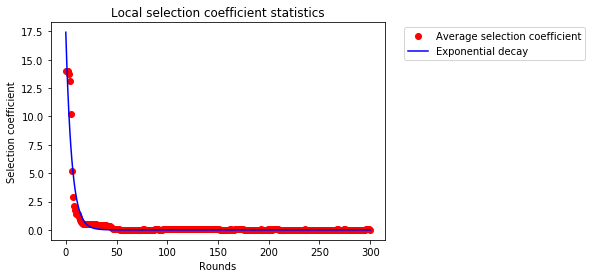

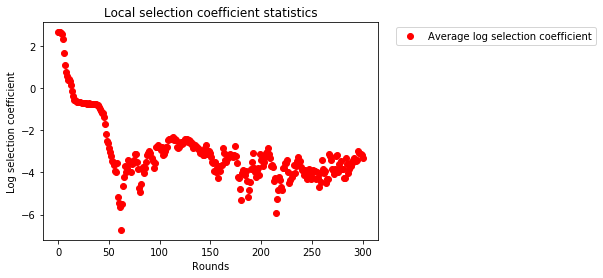

yeah


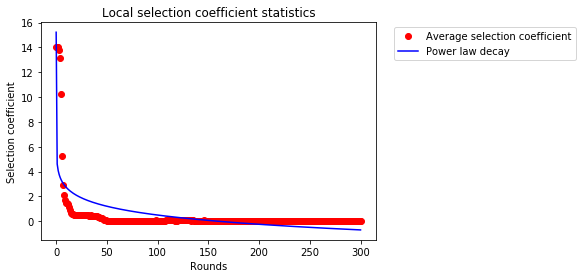

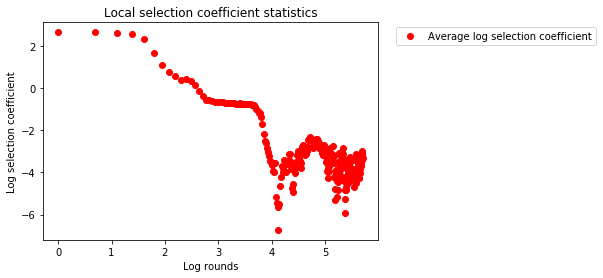

yeah


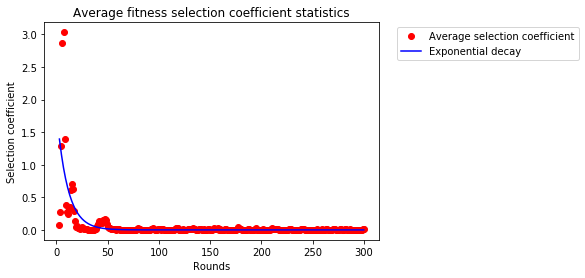

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:312: RuntimeWarning: divide by zero encountered in log


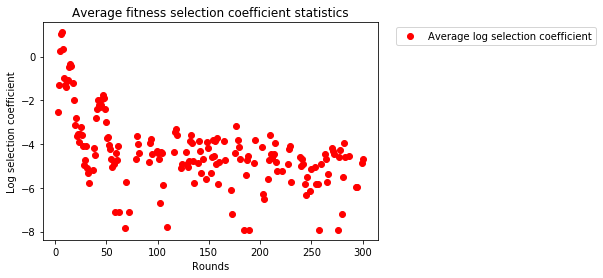

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:259: RuntimeWarning: overflow encountered in multiply


yeah


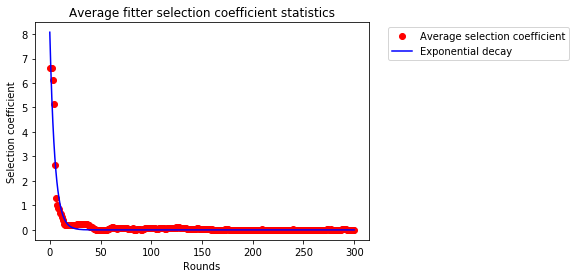

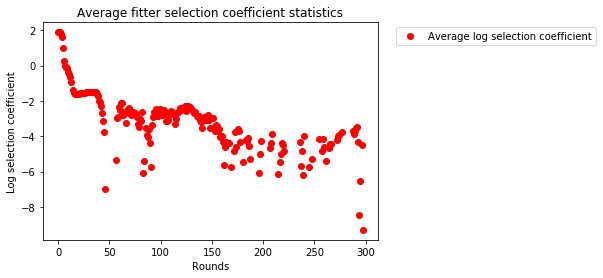

yeah


/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: divide by zero encountered in power


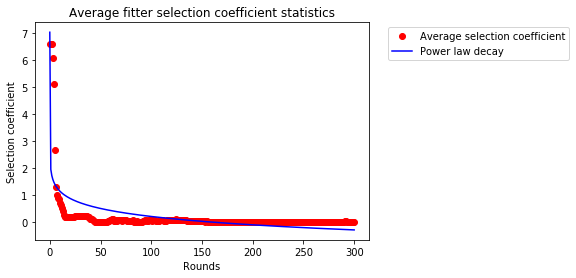

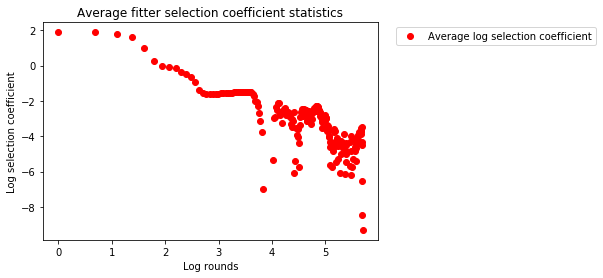

yeah


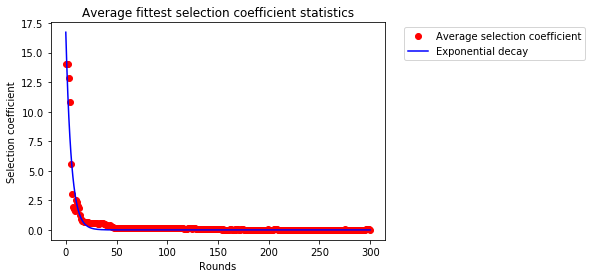

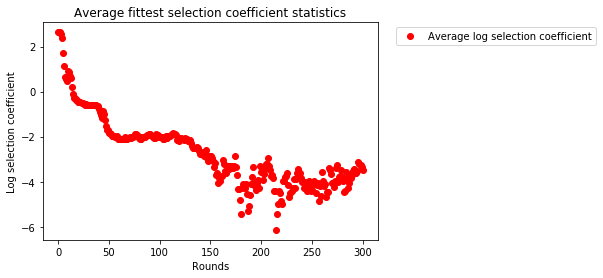

yeah


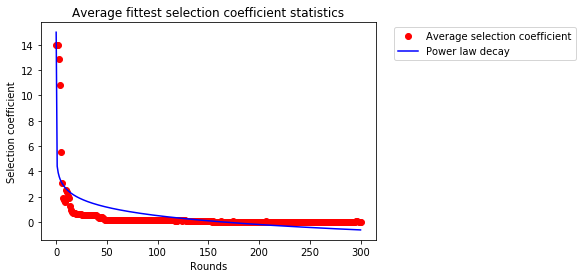

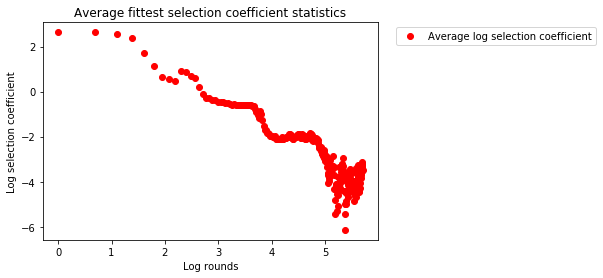

yeah


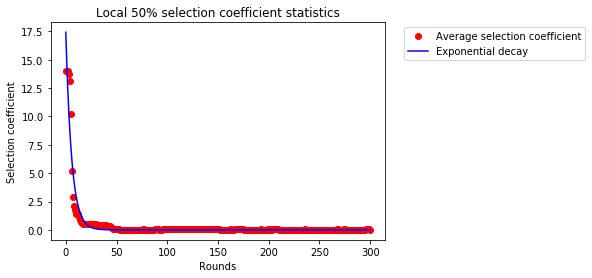

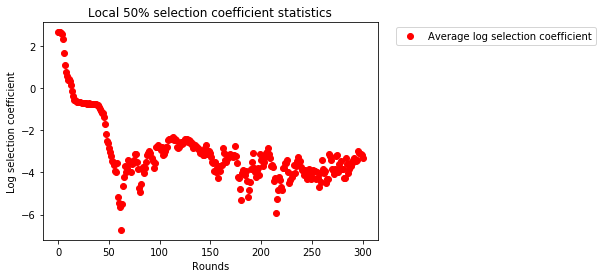

yeah


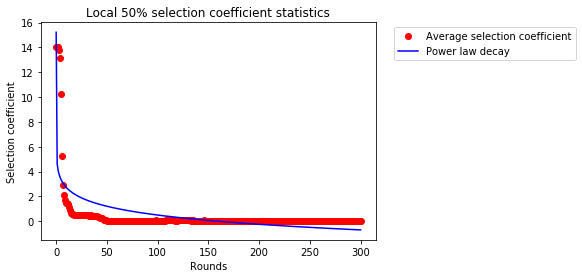

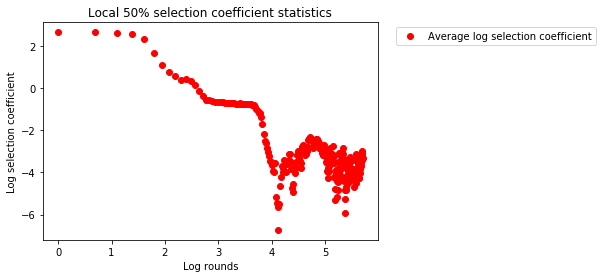

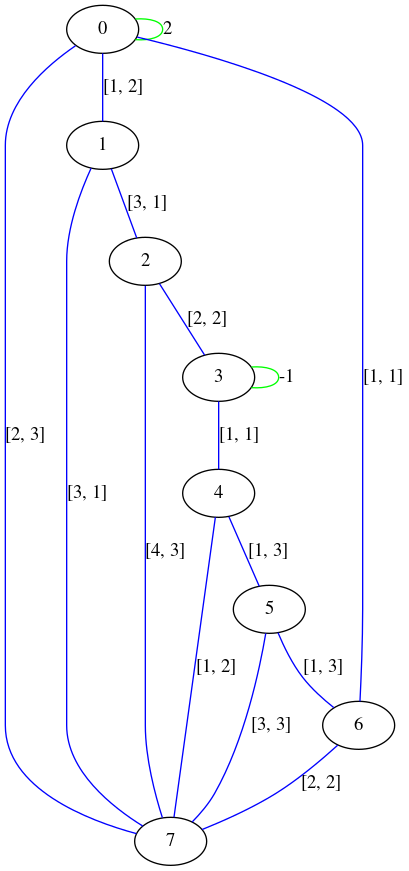

In [214]:
initial = [0] * 8
probability = 0.01
rounds = 300
orgNum = 100
cons1 = ConstraintBinaryModelUnary(0, 2)
cons2 = ConstraintBinaryModelUnary(3, -1)
cons3 = ConstraintBinaryModelBinaryDifferent([0,7],[2,3])
cons4 = ConstraintBinaryModelBinaryDifferent([0,1],[1,2])
cons5 = ConstraintBinaryModelBinaryDifferent([1,7],[3,1])
cons6 = ConstraintBinaryModelBinaryDifferent([1,2],[3,1])
cons7 = ConstraintBinaryModelBinaryDifferent([7,2],[4,3])
cons8 = ConstraintBinaryModelBinaryDifferent([2,3],[2,2])
cons9 = ConstraintBinaryModelBinaryDifferent([4,3],[1,1])
cons10 = ConstraintBinaryModelBinaryDifferent([4,7],[1,2])
cons11 = ConstraintBinaryModelBinaryDifferent([4,5],[1,3])
cons12 = ConstraintBinaryModelBinaryDifferent([7,5],[3,3])
cons13 = ConstraintBinaryModelBinaryDifferent([6,5],[1,3])
cons14 = ConstraintBinaryModelBinaryDifferent([6,7],[2,2])
cons15 = ConstraintBinaryModelBinaryDifferent([6,0],[1,1])
constraints = [cons1,cons2,cons3,cons4,cons5,cons6,cons7,cons8,cons9,cons10,cons11,cons12,cons13,cons14,cons15]

mySim = Simulator(2, initial, probability, rounds, orgNum, constraints, None, 1, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()
G = mySim.plotConstraintGraph()
draw(G, show = 'ipynb')

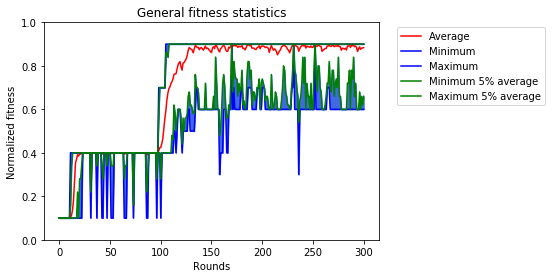

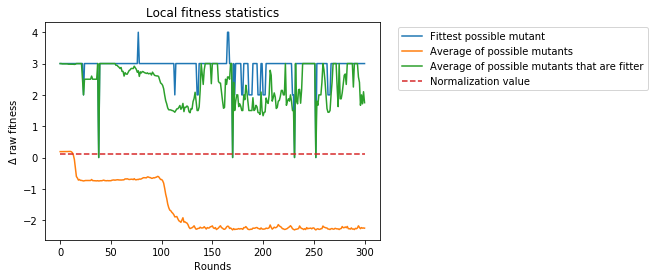

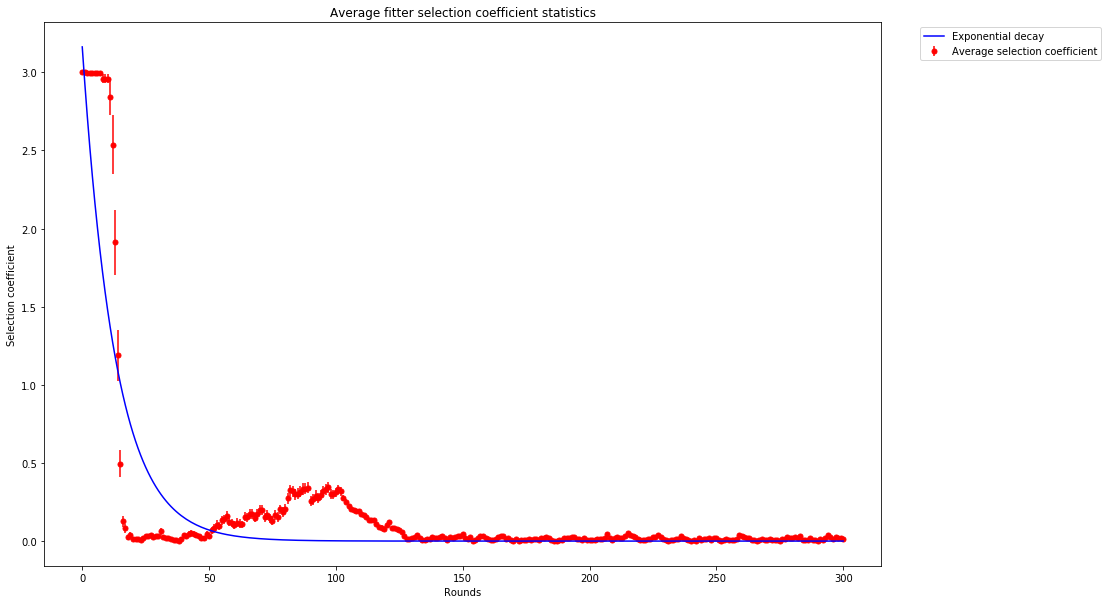

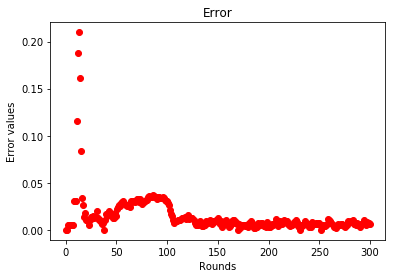

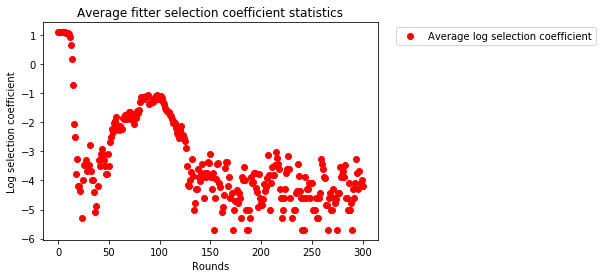

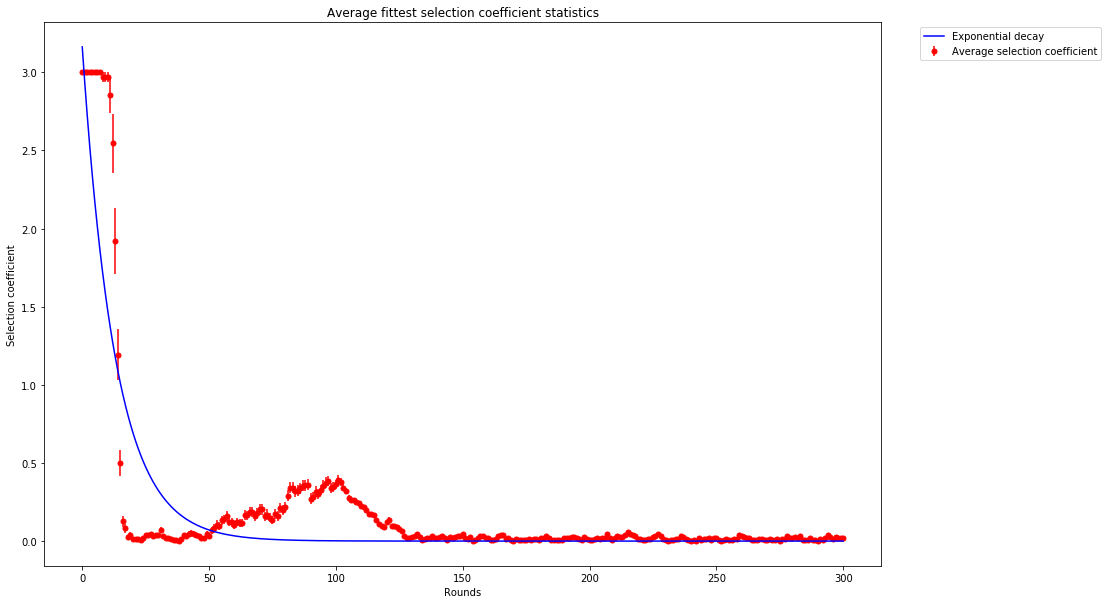

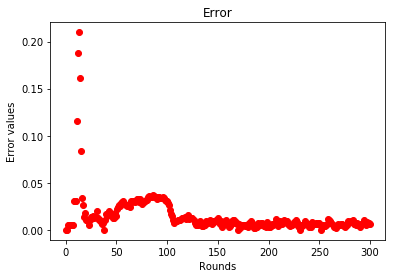

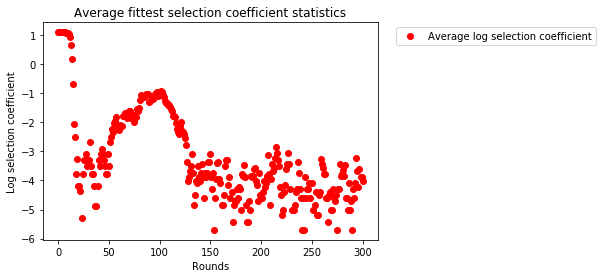

CPU times: user 5.09 s, sys: 1.75 s, total: 6.85 s
Wall time: 4.27 s


In [10]:
%%time

initial = [0,0,0,0,0,0,0,0]
probability = 0.01
rounds = 300
orgNum = 100
cons1 = ConstraintWCSP(([0,1],[["red", "red"]]), 2)
cons2 = ConstraintWCSP(([2,3],[["blue", "yellow"]]), 3)
cons3 = ConstraintWCSP(([5,6,7],[["blue", "red", "red"]]), 3)
cons4 = ConstraintWCSP(([1,6,7],[["yellow", "red", "red"]]), 1)
constraints = [cons1, cons2, cons3, cons4]
domain = ["blue", "red", "yellow"]
domains = [domain] * 8

mySim = Simulator(4, initial, probability, rounds, orgNum, constraints, domains, 1, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

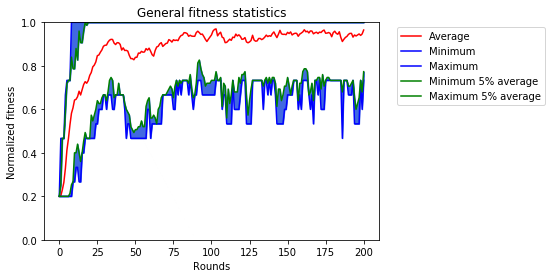

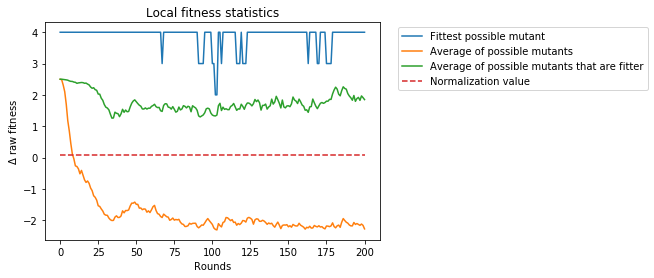

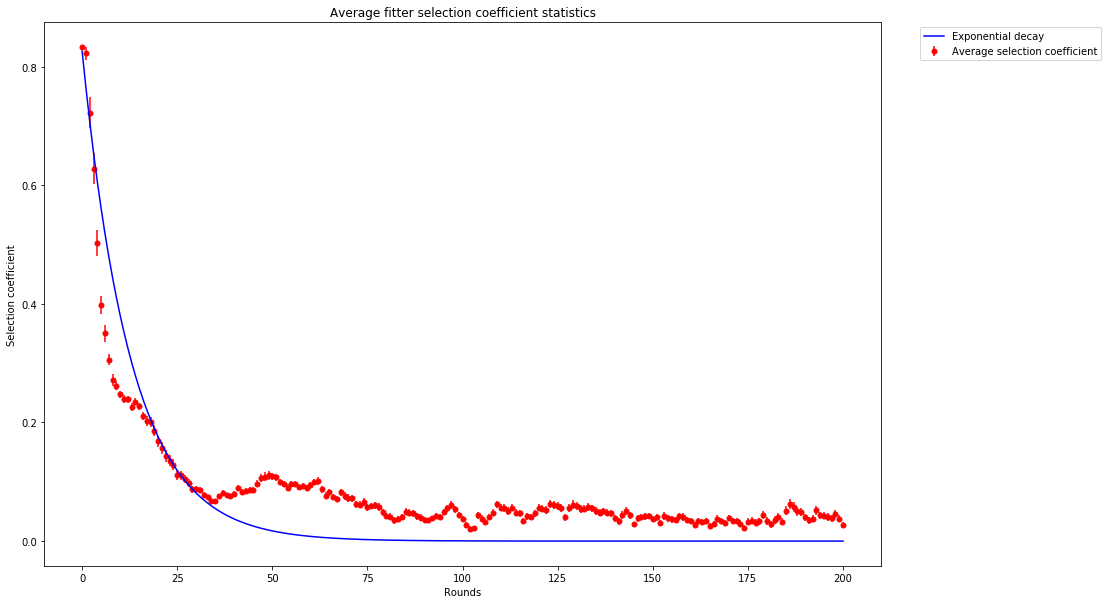

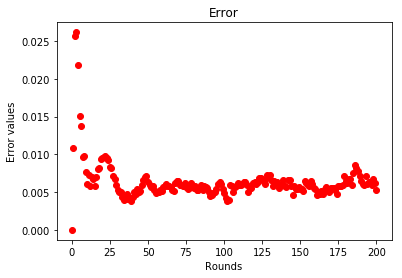

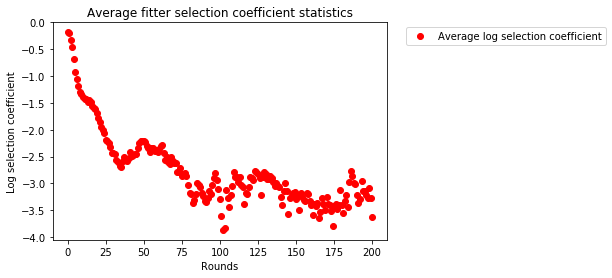

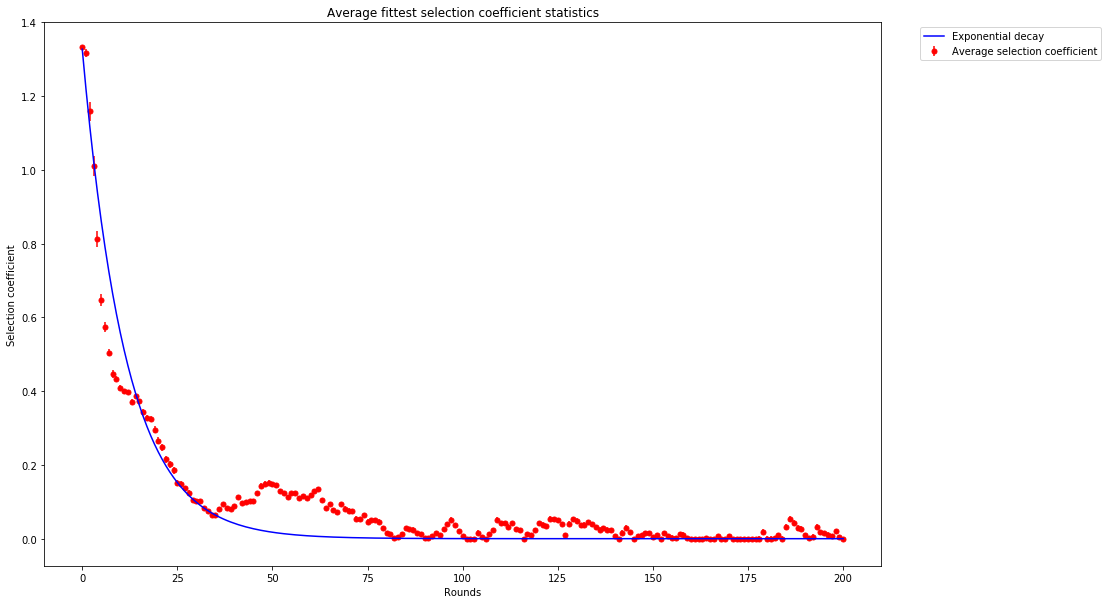

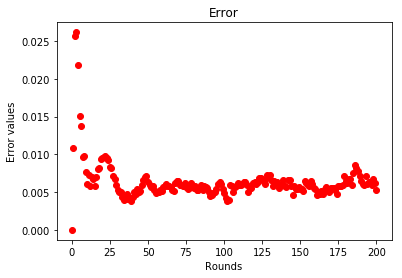

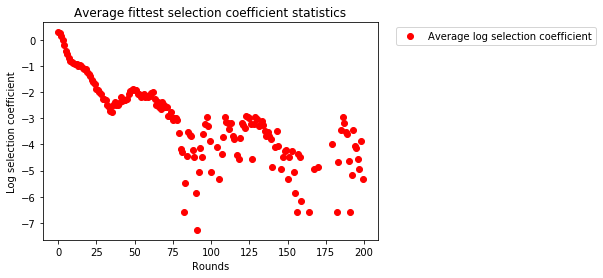

In [3]:
initial = [0,0,0]
probability = [0.005, 0.01, 0.015]
rounds = 200
orgNum = 100
def myFunc(args):
    return sum(args)
cons = ConstraintVCSP([0,1,2],(myFunc,15))
domain = [1,2,3,4,5]
domains = [domain] * 3
constraints = [cons]

mySim = Simulator(3, initial, probability, rounds, orgNum, constraints, domains, 0, 0)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

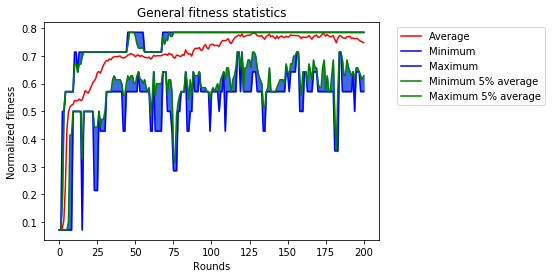

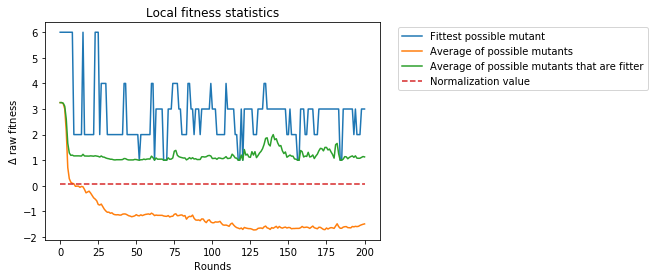

yeah


/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:259: RuntimeWarning: overflow encountered in exp
/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:259: RuntimeWarning: overflow encountered in multiply


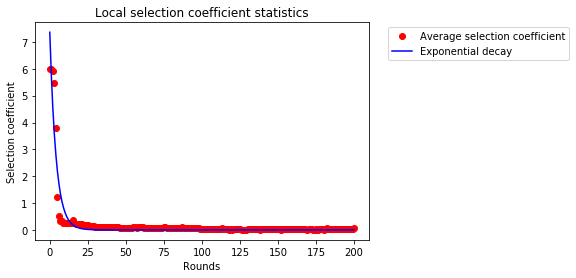

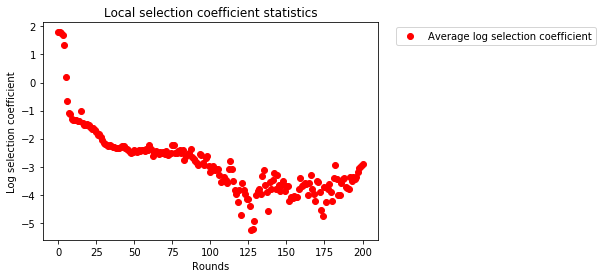

yeah


/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:261: RuntimeWarning: divide by zero encountered in power


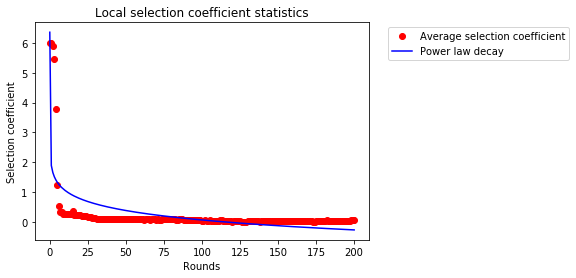

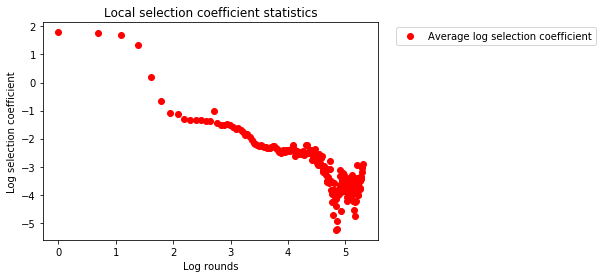

yeah


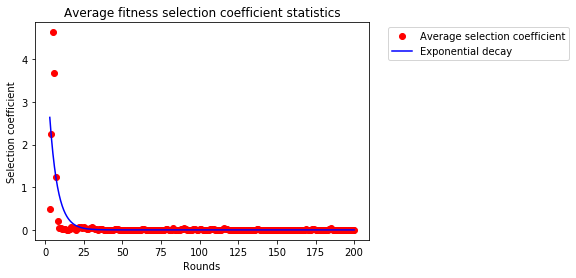

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:312: RuntimeWarning: divide by zero encountered in log


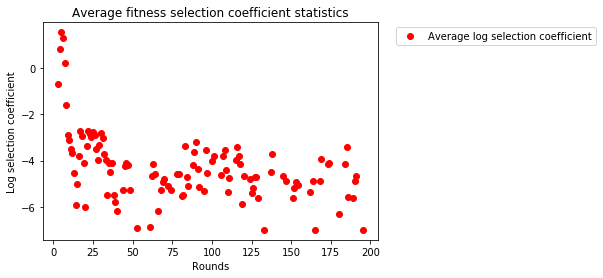

yeah


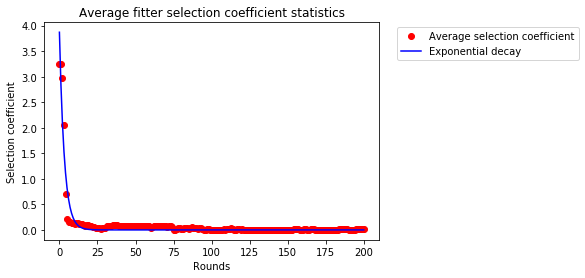

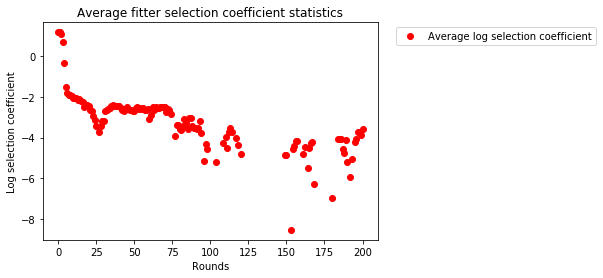

yeah


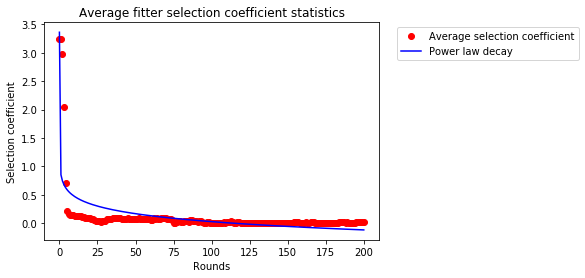

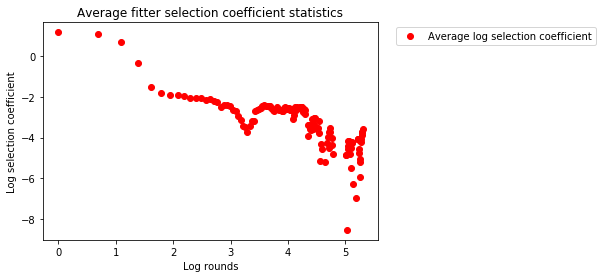

yeah


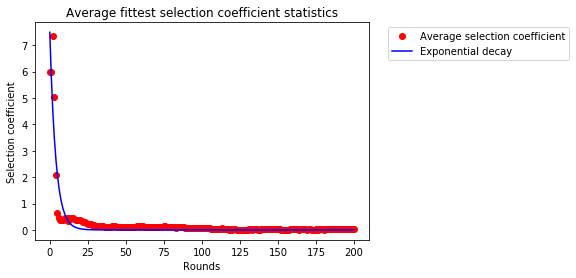

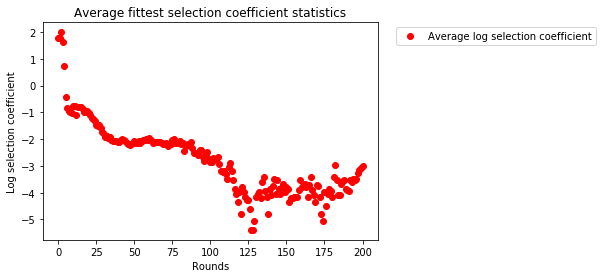

yeah


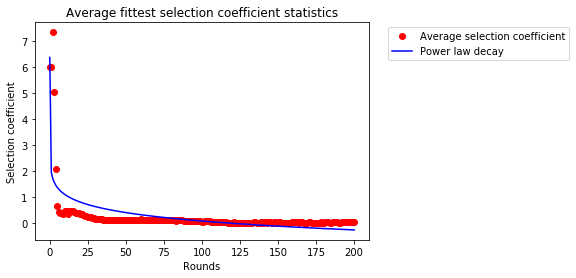

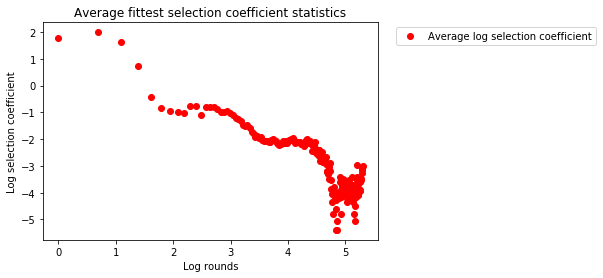

yeah


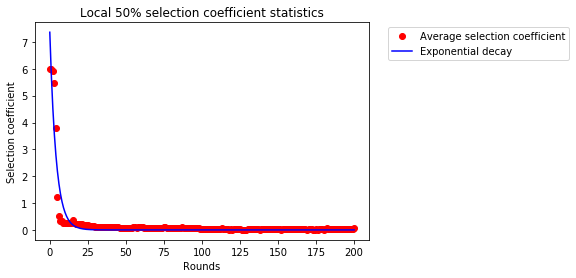

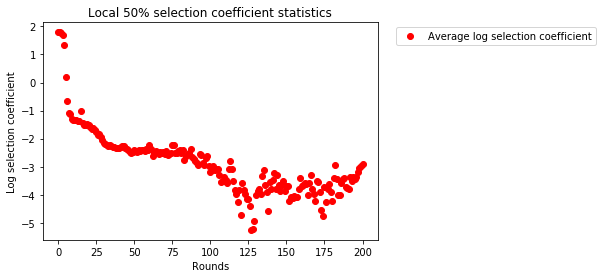

yeah


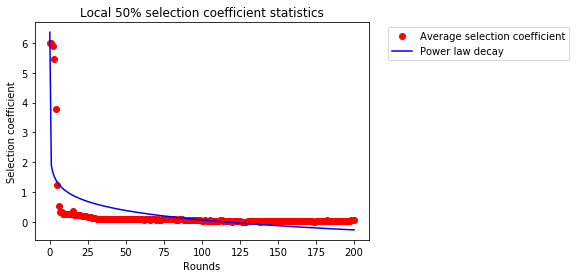

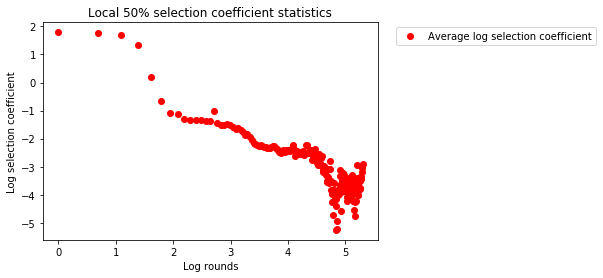

In [221]:
initial = [0] * 8
probability = 0.01
rounds = 200
orgNum = 100
cons3 = ConstraintBinaryModelBinaryDifferent([0,7],[1,1])
cons4 = ConstraintBinaryModelBinaryDifferent([0,1],[1,1])
cons5 = ConstraintBinaryModelBinaryDifferent([1,7],[1,1])
cons6 = ConstraintBinaryModelBinaryDifferent([1,2],[1,1])
cons7 = ConstraintBinaryModelBinaryDifferent([7,2],[1,1])
cons8 = ConstraintBinaryModelBinaryDifferent([2,3],[1,1])
cons9 = ConstraintBinaryModelBinaryDifferent([4,3],[1,1])
cons10 = ConstraintBinaryModelBinaryDifferent([4,7],[1,1])
cons11 = ConstraintBinaryModelBinaryDifferent([4,5],[1,1])
cons12 = ConstraintBinaryModelBinaryDifferent([7,5],[1,1])
cons13 = ConstraintBinaryModelBinaryDifferent([6,5],[1,1])
cons14 = ConstraintBinaryModelBinaryDifferent([6,7],[1,1])
cons15 = ConstraintBinaryModelBinaryDifferent([6,0],[1,1])
constraints = [cons3,cons4,cons5,cons6,cons7,cons8,cons9,cons10,cons11,cons12,cons13,cons14,cons15]

mySim = Simulator(2, initial, probability, rounds, orgNum, constraints, None, 1, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

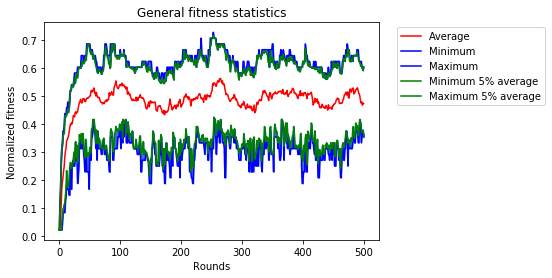

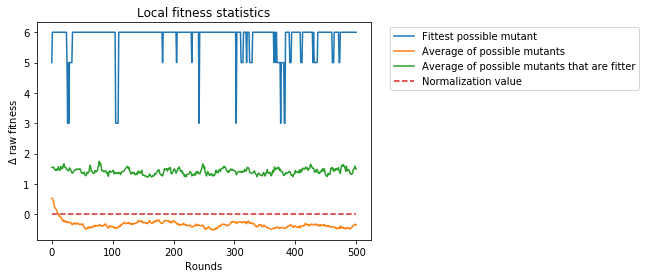

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: RuntimeWarning: overflow encountered in multiply


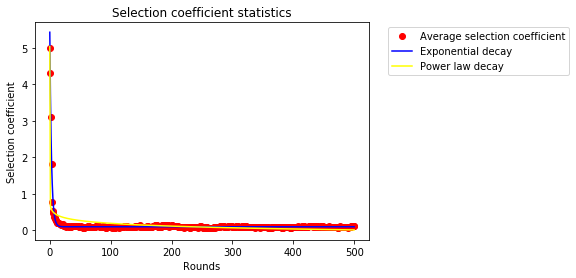

CPU times: user 1min 15s, sys: 11.9 ms, total: 1min 15s
Wall time: 1min 15s


In [59]:
%%time

initial = [0] * 32
probability = [0.01] * 32
rounds = 500
orgNum = 100
clause1 = ConstraintSat([1,5,7],1)
clause2 = ConstraintSat([2,1,3],2)
clause3 = ConstraintSat([-3,5,7],1)
clause4 = ConstraintSat([4,2],1)
clause5 = ConstraintSat([-5,3],2)
clause6 = ConstraintSat([-6,18],1)
clause7 = ConstraintSat([7,23],1)
clause8 = ConstraintSat([8,-19],3)
clause9 = ConstraintSat([9,-1],1)
clause10 = ConstraintSat([10,-6],1)
clause11 = ConstraintSat([11,-12,-22],2)
clause12 = ConstraintSat([12,11],1)
clause13 = ConstraintSat([13,14],1)
clause14 = ConstraintSat([14,-1],5)
clause15 = ConstraintSat([15,-29],1)
clause16 = ConstraintSat([16,32],1)
clause17 = ConstraintSat([17,-31],1)
clause18 = ConstraintSat([18,5],1)
clause19 = ConstraintSat([19,4],1)
clause20 = ConstraintSat([20,17],3)
clause21 = ConstraintSat([21,-7],1)
clause22 = ConstraintSat([22,-2],1)
clause23 = ConstraintSat([-23,4],1)
clause24 = ConstraintSat([24,-7],1)
clause25 = ConstraintSat([25,-6],1)
clause26 = ConstraintSat([26,-2],1)
clause27 = ConstraintSat([27],2)
clause28 = ConstraintSat([28],1)
clause29 = ConstraintSat([29],3)
clause30 = ConstraintSat([30],1)
clause31 = ConstraintSat([31],2)
clause32 = ConstraintSat([32],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8, clause9, clause10, clause11, clause12, clause13, clause14, clause15, clause16, clause17, clause18, clause19, clause20, clause21, clause22, clause23, clause24, clause25, clause26, clause27, clause28, clause29, clause30, clause31, clause32]

mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

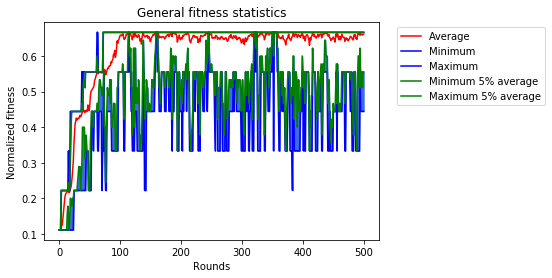

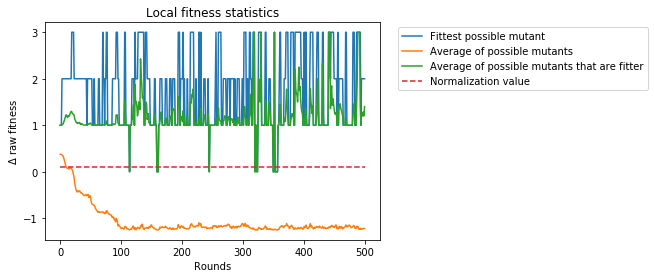

yeah


/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:259: RuntimeWarning: overflow encountered in exp


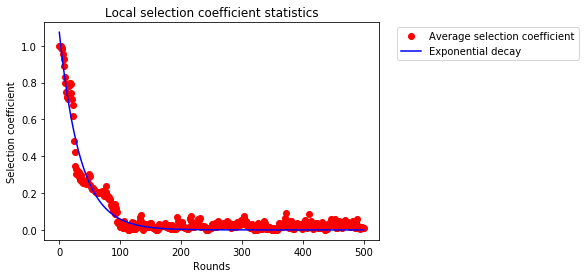

/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:312: RuntimeWarning: divide by zero encountered in log


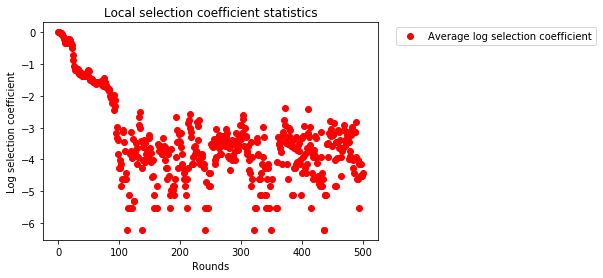

yeah


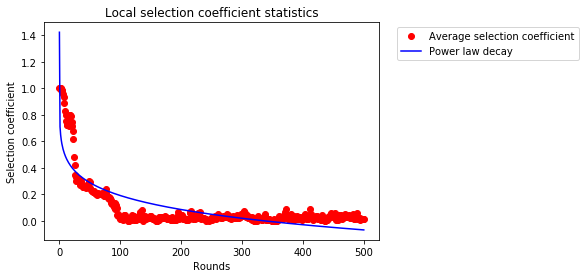

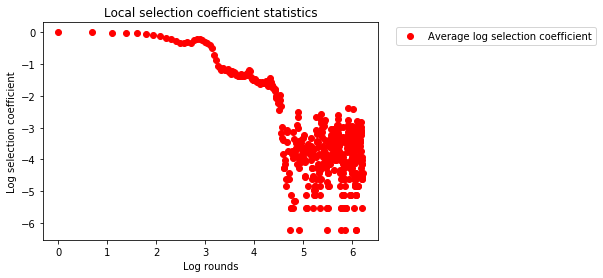

yeah


/home/alexandru/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:259: RuntimeWarning: overflow encountered in multiply


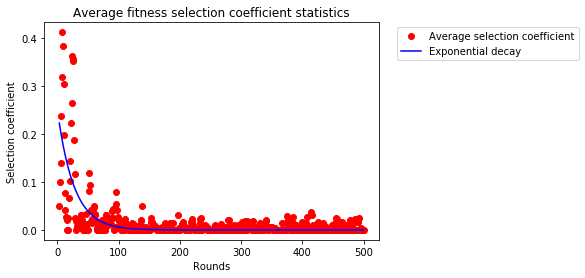

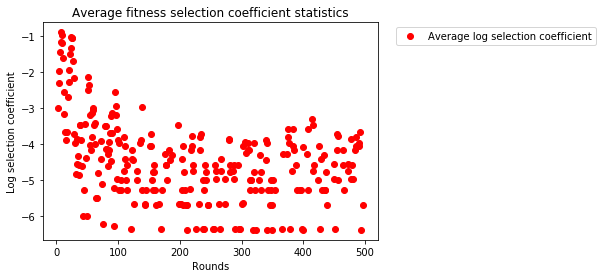

yeah


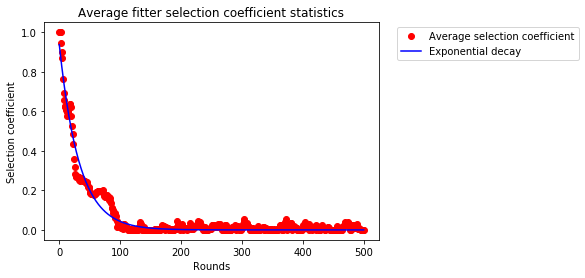

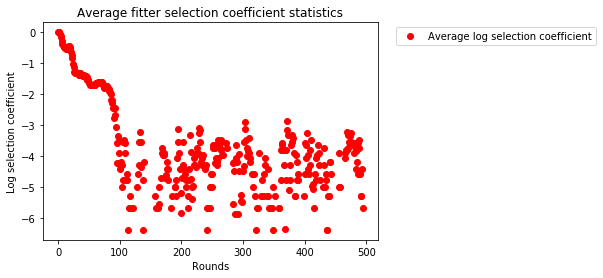

yeah


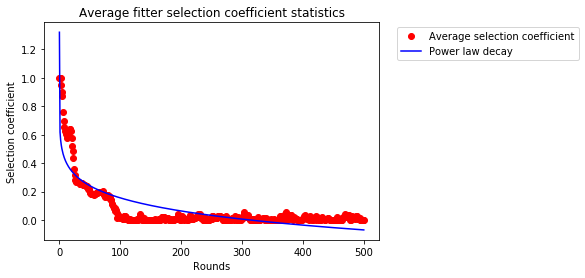

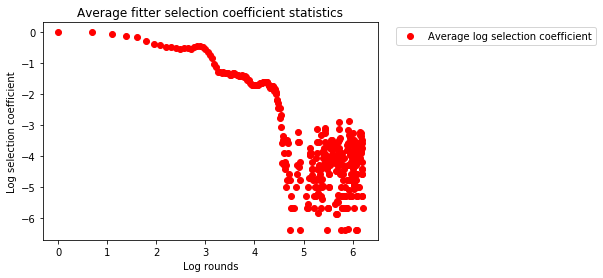

yeah


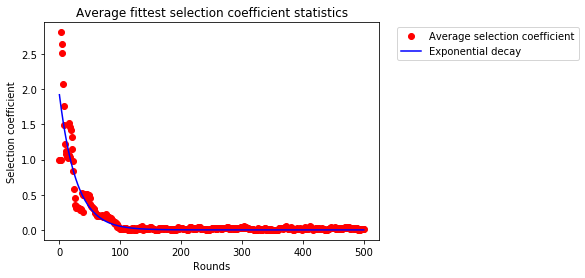

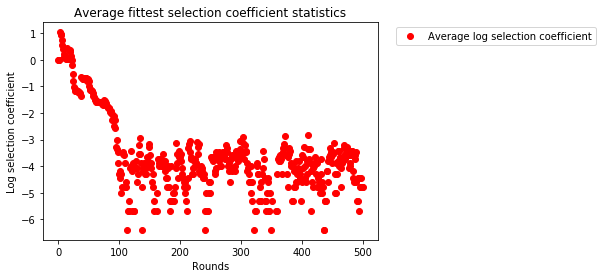

yeah


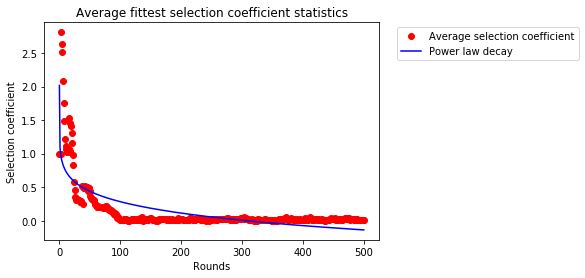

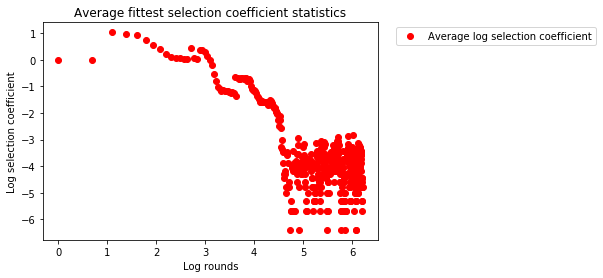

yeah


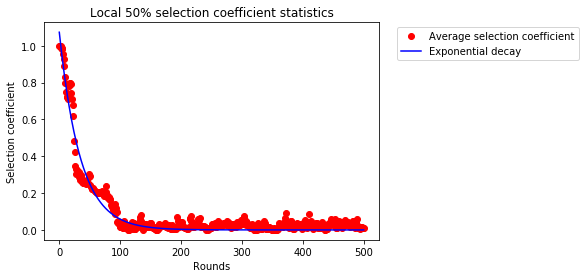

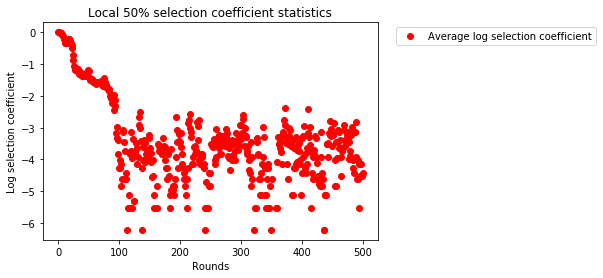

yeah


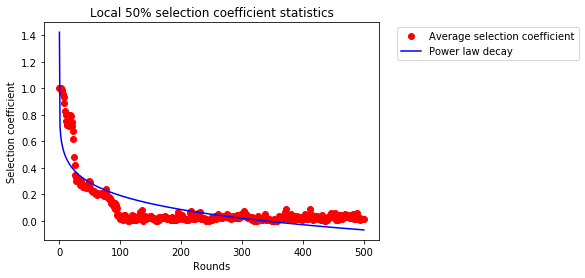

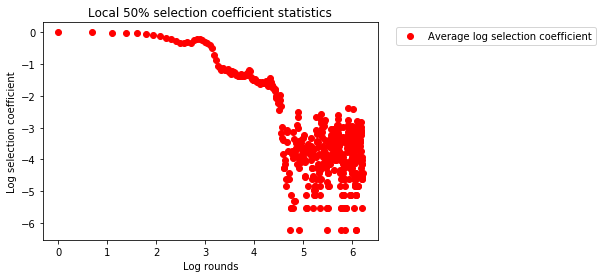

CPU times: user 11.4 s, sys: 4.82 s, total: 16.2 s
Wall time: 9.4 s


In [226]:
%%time

initial = [0, 0, 0, 0, 0, 0, 0, 0]
probability = 0.01
rounds = 500
orgNum = 100
clause1 = ConstraintSat([1,2,3],1)
clause2 = ConstraintSat([5,-4,7],1)
clause3 = ConstraintSat([6,7],1)
clause4 = ConstraintSat([1,-2],1)
clause5 = ConstraintSat([5,8],1)
clause6 = ConstraintSat([6,-8],1)
clause7 = ConstraintSat([7,-3],1)
clause8 = ConstraintSat([8,3],1)
clauses = [clause1, clause2, clause3, clause4, clause5, clause6, clause7, clause8]

mySim = Simulator(1, initial, probability, rounds, orgNum, clauses, None, 1, 1)
mySim.run()
mySim.printStatistics()
mySim.printLocalStatistics()

In [ ]:
#Observations:
#    Under this model, they tend to converge to an optimum quite fast
    
#What to do:
#    How to select the children / try various methods
#    For local statistics, how to plot the individuals
#    Use joyplots

[3]
